# Single cell evaluation of co-regulated genes

This notebook aims to evaluate the co-expression of genes identified to be co-regulated in the CPTAC dataset (https://www.sciencedirect.com/science/article/pii/S0092867419311237), a dataset of 110 patients and protein, RNAseq and DNA methylation data. We're looking at a form of Kidney cancer (ccRCC) clear cell renal cell carcinoma. This affects alot of people (ths most common form of kidney cancer). It is an interesting cancer because of the metabolic rewiring that the cells undergo, in addition of aberant DNA hyper methylation. We're aiming to see if by identifiying co-regulated genes, we can work out on which level they are best targetted with drugs. The first part of the paper was identifying the regulatory groups based on changes in tumour vs normal. The second part is identifying which of these genes change between early and late stage patients. We're interested in using the single cell data to determine whether the genes that change in late and early stage are co-expressed at the single cell level (and then likely to be actually in those cancer cells working together at least that is what we're using this evidence to suggest.)


The single cell data comes from: 
https://www.sciencedirect.com/science/article/pii/S1535610821001653?via%3Dihub 
- Single-cell RNA-seq reveals the architecture of the ccRCC immune microenvironment  
- Multiregional immune phenotypes integrated with bulk RNA-seq and tumor pathology  
- TCR usage varies by phenotype and defines T cell differentiation trajectories  
- Signatures of tissue-resident T cells and TAMs predict clinical outcome  

#### Summary from single cell paper:  
Clear cell renal cell carcinomas (ccRCCs) are highly immune infiltrated, but the effect of immune heterogeneity on clinical outcome in ccRCC has not been fully characterized. Here we perform paired single-cell RNA (scRNA) and T cell receptor (TCR) sequencing of 167,283 cells from multiple tumor regions, lymph node, normal kidney, and peripheral blood of two immune checkpoint blockade (ICB)-naïve and four ICB-treated patients to map the ccRCC immune landscape. We detect extensive heterogeneity within and between patients, with enrichment of CD8A+ tissue-resident T cells in a patient responsive to ICB and tumor-associated macrophages (TAMs) in a resistant patient. A TCR trajectory framework suggests distinct T cell differentiation pathways between patients responding and resistant to ICB. Finally, scRNA-derived signatures of tissue-resident T cells and TAMs are associated with response to ICB and targeted therapies across multiple independent cohorts. Our study establishes a multimodal interrogation of the cellular programs underlying therapeutic efficacy in ccRCC.

#### Figure 2 
Mainly we're interested in the UMAP from Figure 2: Immune landscape of patients with ccRCC at single-cell resolution

(A) UMAP embedding of transcriptional profiles from all patients and samples (n = 167,283). Each dot represents a single cell, and colors represent clusters denoted by inferred cell type.  


#### Data details
Data were downloaded from https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?analysis=SRZ190804 

```
ccRCC_6pat_Seurat	23.4Gb	2021-03-26 10:51:14	c26b3e222bcf6d1f40ef9112864bc9f7
ccRCC_6pat_cell_annotations.txt	20.2Mb	2021-03-26 10:54:30	9c8f646ec8a1f54fa97c2f1524d505b3
ccRCC_TCRs.txt	3.7Mb	2021-03-26 10:54:31	204982b821836f39950627a642218f9f
ccRCC_regions.txt	348b	2021-03-26 10:54:32	af230043d451b477dc44386a0d26d075
```
and then saved to csv's using the following R script:

```
library(Seurat)
library(SeuratData)
library(loomR)
library(tidyverse)
library('Matrix')

devtools::install_github(repo = 'hhoeflin/hdf5r') # Update hdf5r for stability improvements
devtools::install_github(repo = 'mojaveazure/loomR', ref = 'develop') # Update loomR for up-to-date functions

install.packages('SeuratDisk')

singleCell <- readRDS('/Users/ariane/Downloads/ccRCC_6pat_Seurat')
kidney_cc <- UpdateSeuratObject(object = singleCell)

tsne_red <- kidney_cc@reductions[['tsne']]
rna_counts <- kidney_cc@assays[["RNA"]]@counts

writeMM(rna_counts,file='rna_counts_ccRCC_6pat_Seurat.txt')

gene_ids <- kidney_cc@assays[["RNA"]]@counts@Dimnames[[1]]
write.csv(gene_ids, 'geneids_ccRCC_6pat_Seurat.csv')

meta_data <- kidney_cc@meta.data
meta_data <- as.data.frame(meta_data)
write.csv(meta_data, 'metadata_ccRCC_6pat_Seurat.csv')

tsne_red <- kidney_cc@reductions[['tsne']]
tsne_red <- as.data.frame(tsne_red@cell.embeddings)
write.csv(tsne_red, 'tsne_red_ccRCC_6pat_Seurat.csv')

umap_red <- kidney_cc@reductions[['umap']]
umap_red <- as.data.frame(umap_red@cell.embeddings)
write.csv(umap_red, 'umap_red_ccRCC_6pat_Seurat.csv')

```

In [1]:
work_dir = '/Users/ariane/Documents/code/sircle_meth/reproducible/singlecell_SIRCLE/'
import os
os.chdir(work_dir)
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.io import mmread
from collections import defaultdict
import importlib as imp
from itertools import combinations
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib
from scanpy import AnnData


base_dir = '../../'
data_dir = f'{base_dir}data/single_cell/'
output_dir = data_dir
out_plots = f'{base_dir}data/single_cell/'


In [2]:
################################################################################
                        # Loading the data #
################################################################################
""" Shortcut for the below, this is the compiled data. 
data = sc.read_h5ad(data_dir+'ccRCC.h5ad')
late_early_df = data.uns['late_early_df']
"""
reload_data = False
if reload_data:

    # Below compiled all the data into single AnnData, for fast/easy read/write
    counts = mmread(f'{data_dir}rna_counts_ccRCC_6pat_Seurat.txt')
    # This is not relevant, actually.
    cell_annots = pd.read_csv(f'{data_dir}ccRCC_6pat_cell_annotations.txt',
                              index_col=0, sep='\t')
    #meta = pd.concat([meta, cell_annots], axis=1)
    meta = cell_annots
    tsne = pd.read_csv(f'{data_dir}tsne_red_ccRCC_6pat_Seurat.csv', index_col=0)
    umap = pd.read_csv(f'{data_dir}umap_red_ccRCC_6pat_Seurat.csv', index_col=0)
    gene_names = pd.read_csv(f'{data_dir}geneids_ccRCC_6pat_Seurat.csv',
                             index_col=0)
    for df in [tsne, umap]:
        print(np.all(meta.index.values==df.index.values)) # All True!

    counts_frame = pd.DataFrame.sparse.from_spmatrix(counts,
                                           index=gene_names.values[:,0].astype(str),
                                  columns=meta.index.values.astype(str)).transpose()

    # Read in the output from our analysis

    ##### Creating AnnData for fast read/write access #######
    data = AnnData(counts_frame, obs=meta)
    data.obsm['X_umap'] = umap.values
    data.obsm['X_tsne'] = tsne.values

    ###### Need to convert all string annotations to categorical to get save to work
    #### TODO NOTE: Not necesary, error *was* due to duplicate columns in meta
    new_obs = data.obs
    for col in new_obs.columns:
        if new_obs[col].dtype == 'O':
            new_vals = new_obs[col].values.astype(str)
            new_obs[col] = new_vals
            new_obs[col] = new_obs[col].astype('category')
    data.obs = new_obs

    ###### Saving AnnData!
    data.write_h5ad(data_dir+'ccRCC.h5ad', compression='gzip')


In [3]:
data = sc.read_h5ad(data_dir+'ccRCC.h5ad')

In [4]:
cell_annots = pd.read_csv(f'{data_dir}ccRCC_6pat_cell_annotations.txt',
                          index_col=0, sep='\t')
len(list(set(cell_annots.cluster_name)))

31

## Loading the data

(167283, 16323)


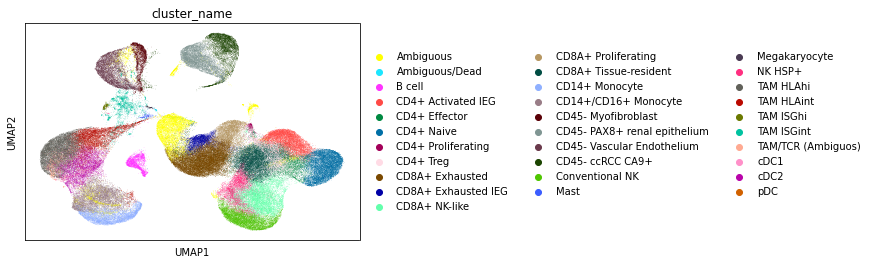

In [5]:
print(data.shape) #cells by genes
sc.pl.umap(data, color='cluster_name')

### Loading the gene modules


MDS 2 1 1.26925235 -1.4879704
MDS_TMDE 49 8 0.58025414 -0.8708036
MDE 0 2 nan -1.2964739
MDE_TMDS 162 26 0.610698075 -0.68764185
TMDE 23 7 0.8885946 -1.031239
TMDS 29 3 1.2288947 -1.3339274
TPDE 1 13 0.95921123 -1.2569926
TPDE_TMDS 117 15 0.57853997 -0.7242036
TPDS 9 3 1.3462479 -1.1079198
TPDS_TMDE 146 14 0.602266105 -0.80887113


MDS 2 1 1.26925235 -1.4879704
MDS_TMDE 37 8 0.69926214 -0.8708036
MDE 0 2 nan -1.2964739
MDE_TMDS 98 26 0.94831868 -0.68764185
TMDE 23 7 0.8885946 -1.031239
TMDS 29 3 1.2288947 -1.3339274
TPDE 1 13 0.95921123 -1.2569926
TPDE_TMDS 70 15 0.80569685 -0.7242036
TPDS 9 3 1.3462479 -1.1079198
TPDS_TMDE 97 14 0.69960546 -0.80887113

## Calling DE for the gene modules using One-Versus-Rest comparison of cell types

### First need to preprocess, normalise, log1p data.

In [6]:
sc.pp.calculate_qc_metrics(data, percent_top=None, log1p=False, inplace=True)

### Normalisation & log1p

Woah, they keeping some low quality cells in the original paper, Only 223 reads minimum, should be 600 atleast...Anyhow, pretending this isn't a problem...

In [7]:
print(data.shape)
sc.pp.filter_genes(data, min_cells=3) #in-place filtering.. nothing filtered
print(data.shape)

sc.pp.normalize_total(data)
sc.pp.log1p(data)

(167283, 16323)
(167283, 16323)


## Getting which of the module genes are DE..

In [8]:
gene_id = 'id'
save_figs = True
run_label = 'PBRM1-BAP1' # Stage4-Stage1, Late-Early
#run_label = 'Stage IV-Stage I' #'
integrated_df = pd.read_csv(f'{base_dir}data/S050_CCRCC_Clark_Cell2019/sircle/integration/output_data/comparisons/mean_Integrated_comparison_{run_label}.csv')
#integrated_df = pd.read_csv(f'{base_dir}Integrated_comparison_{run_label}.csv')
data.uns['integrated_df'] = integrated_df

# get the genes that are in the single cell dataset
single_cell_gene_set = list(data.var_names.values.astype(str))
# Only keep the ones that are in both
integrated_df = integrated_df[integrated_df[gene_id].isin(single_cell_gene_set)]

integrated_diff = f'Integrated diff ({run_label})'
integrated_padj = f'Integrated padj ({run_label})'

# Build a map of gene ID to ene name
gene_name_map = dict(zip(integrated_df.id, integrated_df.hgnc_symbol))

output_dir = f'{base_dir}data/S050_CCRCC_Clark_Cell2019/sircle/integration/output_data/single_cell/figures/'

In [9]:
reg_gene_map = defaultdict(dict)
rcm_labels = ["MDS", "MDE", "TMDE", "TMDS", "TPDE", "TPDS"]
#rcm_labels = ["MDS", "MDS_TMDE", "MDE", "MDE_TMDS", "TMDE", "TMDS", "TPDE", "TPDE_TMDS",  "TPDS", "TPDS_TMDE"]
cluster_gene_map = {}
gene_padj_map = dict() # Used to extract the sig ones later
gene_cluster_map = dict()
selected_genes = []
n = 1000
for regulatory_label in rcm_labels:
    r_df = integrated_df[integrated_df['Regulation_Grouping_2'] == regulatory_label]

    r_df = r_df[r_df[integrated_padj] < 0.05]
    # Filter to only include genes in the singel cell gene list
    top_df = r_df[r_df[integrated_diff] > 0]  # Get UP and Down genes
    bot_df = r_df[r_df[integrated_diff] < 0]
    
    top_df = top_df.nlargest(n, integrated_diff)
    bot_df = bot_df.nsmallest(n, integrated_diff)
    
    print(regulatory_label, len(top_df), len(bot_df))

    cluster_gene_map[f'{regulatory_label} (+)'] = top_df[gene_id].values
    cluster_gene_map[f'{regulatory_label} (-)'] = bot_df[gene_id].values
    
    # Also add to the selected genes
    selected_genes += list(top_df[gene_id].values) + list(bot_df[gene_id].values)
    
    padj = top_df[integrated_padj].values
    for i, g in enumerate(top_df[gene_id].values):
        gene_padj_map[g] = padj[i] # Just keeping track for magnitude
        gene_cluster_map[g] = f'{regulatory_label} (+)'
    padj = bot_df[integrated_padj].values
    for i, g in enumerate(bot_df[gene_id].values):
        gene_padj_map[g] = padj[i] # Just keeping track for magnitude
        gene_cluster_map[g] = f'{regulatory_label} (-)'

MDS 10 14
MDE 23 40
TMDE 14 24
TMDS 31 58
TPDE 30 32
TPDS 35 55


## Run Scanpy rank genes groups to get genes enriched in each group

/Users/ariane/opt/miniconda3/envs/BINF/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/ariane/opt/miniconda3/envs/BINF/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/ariane/opt/miniconda3/envs/BINF/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:3

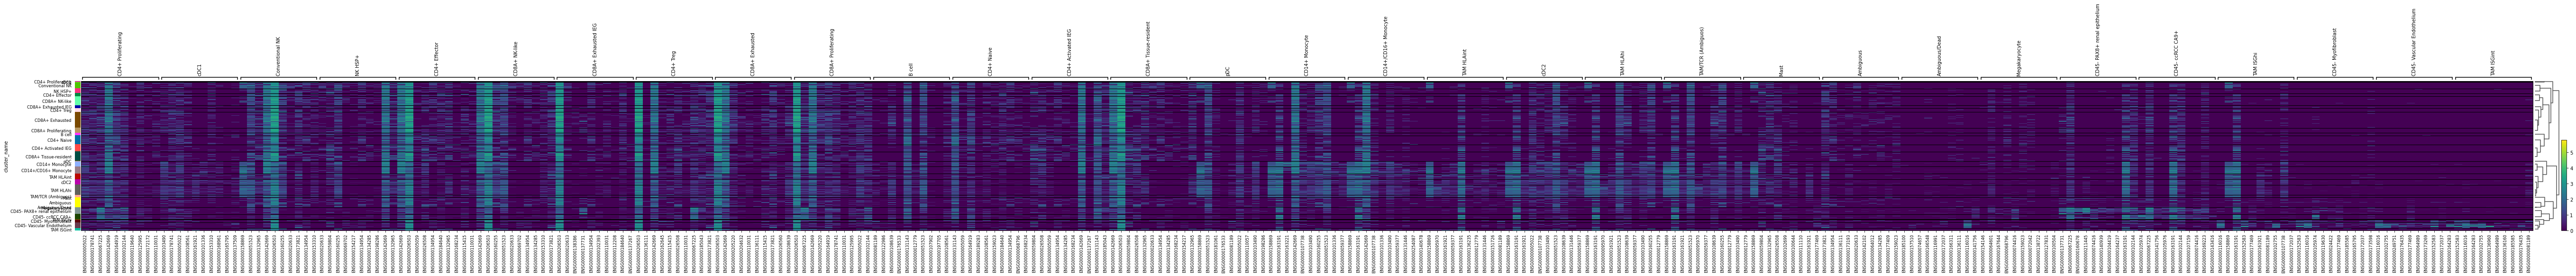

In [10]:
import seaborn as sns
##### Plot heatmap based on the above filtering, to get more specific cell type DE genes.
data_sub_regulatory = data[:,selected_genes]
sc.pp.pca(data_sub_regulatory) # Makes dendrogram construction faster.
sc.tl.dendrogram(data_sub_regulatory, 'cluster_name')
sc.tl.rank_genes_groups(data_sub_regulatory, groupby='cluster_name', use_raw=False, pts=True)
sc.pl.rank_genes_groups_heatmap(data_sub_regulatory,
                                show_gene_labels=True)

# Extract the logFC and rank gene groups from scanpy

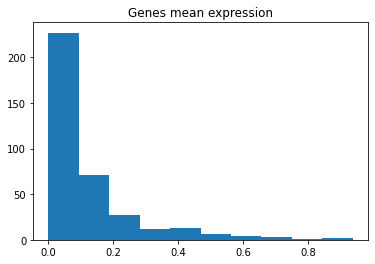

Ambiguous 4
Ambiguous/Dead 0
B cell 9
CD4+ Activated IEG 7
CD4+ Effector 4
CD4+ Naive 11
CD4+ Proliferating 24
CD4+ Treg 7
CD8A+ Exhausted 6
CD8A+ Exhausted IEG 3
CD8A+ NK-like 5
CD8A+ Proliferating 12
CD8A+ Tissue-resident 5
CD14+ Monocyte 40
CD14+/CD16+ Monocyte 42
CD45- Myofibroblast 63
CD45- PAX8+ renal epithelium 163
CD45- Vascular Endothelium 74
CD45- ccRCC CA9+ 132
Conventional NK 8
Mast 6
Megakaryocyte 2
NK HSP+ 11
TAM HLAhi 55
TAM HLAint 35
TAM ISGhi 81
TAM ISGint 46
TAM/TCR (Ambiguos) 29
cDC1 18
cDC2 39
pDC 16


In [11]:
## Each data frame is in the format: columns = cell types, rows = genes.
genes_df = pd.DataFrame(data_sub_regulatory.uns['rank_genes_groups']['names'])
logfcs_df = pd.DataFrame(data_sub_regulatory.uns['rank_genes_groups']['logfoldchanges'])
pvals_df = pd.DataFrame(data_sub_regulatory.uns['rank_genes_groups']['pvals'])
padjs_df = pd.DataFrame(data_sub_regulatory.uns['rank_genes_groups']['pvals_adj'])
prop_expr_df = pd.DataFrame(data_sub_regulatory.uns['rank_genes_groups']['pts'])

mean_expression = np.mean(prop_expr_df.values, axis=1)
# Remove all 
plt.hist(mean_expression)
plt.title('Genes mean expression')
plt.show()

# Make a dataframe for each cell type that captures the logFC, padj and proportion of expression for each gene
cell_dfs = {}
for cell_type in genes_df.columns:
    df = pd.DataFrame()
    df[gene_id] = genes_df[cell_type].values
    df['Cell p.adj'] = padjs_df[cell_type].values
    df['Cell logFC'] = logfcs_df[cell_type].values
    df['Cell prop. expressed'] = prop_expr_df[cell_type].values
    # Now let's just filter to only to keep the ones that are significant
    #cell_dfs['TAM ISGhi'][cell_dfs['TAM ISGhi']['Cell prop. expressed'] == 0]
    df = df[df['Cell prop. expressed'] > 0]
    df = df[df['Cell p.adj'] < 0.05]
    df = df[df['Cell logFC'] > 1.0]
    # the cells
    cell_dfs[cell_type] = df
    print(cell_type, len(df))


## Now count DE genes per module, constructing a contigency table OVR style

Do a fischers exact test to see if any of the differentially expressed genes are co-expressing in the same cell type.

In [12]:
from collections import defaultdict 

# Keep track of the counts in each and also the genes that overlapped
columns = ['Regulatory Cluster label', 'Cell type', 'p-value', 'odds-ratio', 
           'genes in cell type and cluster',  
           'genes in cluster but not cell type', 
           'genes in cell type but not cluster', 
           'genes not in cell type or cluster', 
           'gene_ids', 'gene_names']
rows = []
cluster_cell_gene_ids = defaultdict(dict)
for regulatory_cluster, cluster_genes in cluster_gene_map.items():
    # For each cell type, construct contingency table
    for cell_type, df in cell_dfs.items():
        cell_enriched_genes = df[gene_id].values
        cont_table = np.zeros((2,2)) #Rows=ct, not ct; Cols=Module, not Module
        if len(cell_enriched_genes) > 0: # Some DE genes
            in_cell_and_cluster = len(set(cluster_genes) & set(cell_enriched_genes))
            cluster_not_cell = len(cluster_genes) - in_cell_and_cluster
            cell_not_cluster = len(cell_enriched_genes) - in_cell_and_cluster
            if in_cell_and_cluster > 3:  # Require there to be at least 3 genes overlapping
                not_cell_not_cluster = len(selected_genes) - (in_cell_and_cluster + cluster_not_cell + cell_not_cluster)
                # Populating cont table
                cont_table[0,0] = in_cell_and_cluster
                cont_table[1,0] = cluster_not_cell
                cont_table[0,1] = cell_not_cluster
                cont_table[1,1] = not_cell_not_cluster
                # Doing FET, Enrichment IN cell type, only.
                odds_ratio, pval = fisher_exact(cont_table, alternative="greater")
                genes_ids = list(set(cluster_genes) & set(cell_enriched_genes))
                gene_names = [gene_name_map[gene] for gene in genes_ids]
                cluster_cell_gene_ids[regulatory_cluster][cell_type] = genes_ids
                rows.append([regulatory_cluster, cell_type, pval, odds_ratio, in_cell_and_cluster, 
                             cluster_not_cell, cell_not_cluster, not_cell_not_cluster, ' '.join(genes_ids), ' '.join(gene_names)])

odds_ratio_df = pd.DataFrame(data=rows, columns=columns)
reg, padj, a, b = multipletests(odds_ratio_df['p-value'].values,
                                alpha=0.05, method='fdr_bh', returnsorted=False)
odds_ratio_df['p.adj'] = padj

## Plot the resulting genes and the groups

In [13]:
sig_odds_ratio_df = odds_ratio_df[odds_ratio_df['p.adj'] < 0.05]
sig_odds_ratio_df.to_csv(f'{output_dir}{run_label}_sig_odds_ratio_df.csv', index=False)
odds_ratio_df.to_csv(f'{output_dir}{run_label}_odds_ratio_df.csv', index=False)

In [14]:
# Make a square dataframe based on the odds ratio
rows = []
cell_types = sig_odds_ratio_df['Cell type'].unique()
cluster_labels = sig_odds_ratio_df['Regulatory Cluster label'].unique()

# Let's get an ordered dict of the values so that we can use them later
plotting_gene_map = defaultdict(list) # Get the sig ones since we don't want to plot all!
for cell_type in cell_types:
    values = [cell_type]
    for cluster in cluster_labels:
        cell = sig_odds_ratio_df[sig_odds_ratio_df['Cell type'] == cell_type]
        if len(cell) > 0:
            cell_cluster = cell[cell['Regulatory Cluster label'] == cluster]
            if len(cell_cluster) > 0:
                values.append(cell_cluster['odds-ratio'].values[0])
                # get the genes in this group
                genes = cell_cluster['gene_ids'].values[0].split(' ')
                
                # Add the genes from this group
                gene_to_value = {g:gene_padj_map[g] for g in genes}
                # Sort gene_to_value
                gene_to_value_sorted = dict(sorted(gene_to_value.items(), key=lambda item: item[1]))
                # Get the genes for each of the cell types
                plotting_gene_map[cluster] += list(gene_to_value_sorted.keys())[:5]

            else:
                values.append(0)
        else:
            values.append(0)
    rows.append(values)

square_df = pd.DataFrame(data=rows, columns=['cell type'] + list(cluster_labels))
square_df.set_index('cell type', inplace=True)
# Make sure there weren't any duplicates
for c in plotting_gene_map:
    plotting_gene_map[c] = list(set(plotting_gene_map[c]))

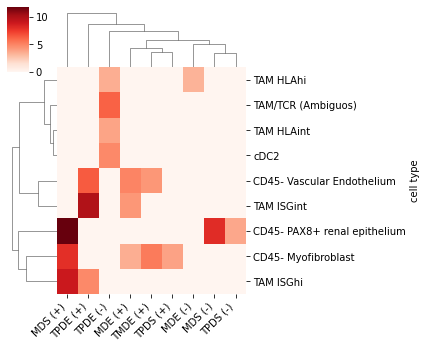

In [15]:
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
ax = sns.clustermap(square_df, cmap="Reds", figsize=(6,5))
plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')
if save_figs:
    plt.savefig(f'{output_dir}{run_label}_heatmap_output_singlecell.svg')

In [16]:
df = pd.DataFrame(data=data.X.todense().T)
df.index = data.var.index # Set the gene names to be the IDs
df.columns = data.obs.index # Set the gene names to be the IDs

In [181]:
###############################################################################
#                                                                             #
#    This program is free software: you can redistribute it and/or modify     #
#    it under the terms of the GNU General Public License as published by     #
#    the Free Software Foundation, either version 3 of the License, or        #
#    (at your option) any later version.                                      #
#                                                                             #
#    This program is distributed in the hope that it will be useful,          #
#    but WITHOUT ANY WARRANTY; without even the implied warranty of           #
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the            #
#    GNU General Public License for more details.                             #
#                                                                             #
#    You should have received a copy of the GNU General Public License        #
#    along with this program. If not, see <http://www.gnu.org/licenses/>.     #
#                                                                             #
###############################################################################

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch

from sciviso import Vis


class Heatmap(Vis):

    def __init__(self, df: pd.DataFrame, chart_columns: list, row_index: str, title='', xlabel='', ylabel='',
                 cluster_rows=True, cluster_cols=True, row_colours=None, col_colours=None, vmin=None, vmax=None,
                 linewidths=0.5, x_tick_labels=1, y_tick_labels=1, rows_to_colour=None, cols_to_colour=None,
                 figsize=(3, 3), title_font_size=8, label_font_size=6, title_font_weight=700, cmap='RdBu_r',
                 annot=None, color_palettes=None,
                 config={}):
        super().__init__(df, figsize=figsize, title_font_size=title_font_size, label_font_size=label_font_size,
                         title_font_weight=title_font_weight)
        self.chart_columns = chart_columns
        self.row_index = row_index
        self.title = title
        self.cluster_rows = cluster_rows
        self.cluster_cols = cluster_cols
        self.col_colours = col_colours
        self.row_colours = row_colours
        self.rows_to_colour = rows_to_colour
        self.cols_to_colour = cols_to_colour
        self.vmin = vmin
        self.vmax = vmax
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.cmap_str = cmap
        self.color_palettes = color_palettes if color_palettes else [
            'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr',
            'Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
                      'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
                      'tab20c']
        self.x_tick_labels = x_tick_labels
        self.y_tick_labels = y_tick_labels
        self.linewidths = linewidths
        self.annot = annot
        self.axis_line_width = 1.0
        if config:
            self.load_style(config)

    def plot(self, ax=None, linecolor="none"):
        self.check_args_in_columns([self.chart_columns, [self.row_index]])
        df_dists = pd.DataFrame(self.df[self.chart_columns].values)
        df_dists.columns = self.chart_columns
        df_dists.index = self.df[self.row_index].values
        # Check if the user has got row_colours defined
        if self.rows_to_colour:
            self.row_colours = []
            for i, rc in enumerate(self.rows_to_colour):
                labels = self.df[rc].values
                lut = dict(zip(set(labels), sns.color_palette(self.color_palettes[i], len(set(labels)))))
                self.row_colours.append(pd.DataFrame(labels)[0].map(lut))
        if ax:
            ax = sns.clustermap(df_dists, col_cluster=self.cluster_cols, figsize=self.figsize, row_cluster=self.cluster_rows,
                                col_colors=self.col_colours, ax=ax,
                                row_colors=self.row_colours, cmap=self.cmap_str, vmax=self.vmax, vmin=self.vmin,
                                yticklabels=self.y_tick_labels, xticklabels=self.x_tick_labels, linewidths=self.linewidths, linecolor=linecolor)
        else:
            ax = sns.clustermap(df_dists, col_cluster=self.cluster_cols, figsize=self.figsize, row_cluster=self.cluster_rows,
                                col_colors=self.col_colours,
                                row_colors=self.row_colours, cmap=self.cmap_str, vmax=self.vmax, vmin=self.vmin,
                                yticklabels=self.y_tick_labels, xticklabels=self.x_tick_labels,
                                linewidths=self.linewidths,
                                linecolor=linecolor)
        if self.rows_to_colour:
            for i, rc in enumerate(self.rows_to_colour):
                labels = self.df[rc].values
                lut = dict(zip(set(labels), sns.color_palette(self.color_palettes[i], len(set(labels)))))
                handles = [Patch(facecolor=lut[name]) for name in lut]
                legend = plt.legend(handles, lut, bbox_to_anchor=(2, i))
                plt.gca().add_artist(legend)

        plt.title(self.title)
        plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
        plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')
        ax.ax_heatmap.tick_params(labelsize=self.label_font_size)
        self.add_labels(title=False, x=False)
        ax.fig.suptitle(self.title, fontsize=self.title_font_size, fontweight=self.title_font_weight)
        ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize=self.label_font_size)
        self.set_ax_params(ax.ax_heatmap)
        plt.tight_layout()
        return ax

    def plot_hm(self, ax=None, linecolor="black"):
        self.check_args_in_columns([self.chart_columns, [self.row_index]])
        df_dists = pd.DataFrame(self.df[self.chart_columns].values)
        df_dists.columns = self.chart_columns
        df_dists.index = self.df[self.row_index].values
        if ax:
            ax = sns.heatmap(df_dists,
                             ax=ax, cmap=self.cmap_str, vmax=self.vmax, vmin=self.vmin, annot=self.annot,
                             yticklabels=self.y_tick_labels, xticklabels=self.x_tick_labels, linewidths=self.linewidths,
                             linecolor=linecolor)
        else:
            ax = sns.heatmap(df_dists, cmap=self.cmap_str, vmax=self.vmax, vmin=self.vmin, annot=self.annot,
                             yticklabels=self.y_tick_labels, xticklabels=self.x_tick_labels, linewidths=self.linewidths,
                             linecolor=linecolor)
        plt.title(self.title)
        plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')
        ax.tick_params(labelsize=self.label_font_size)
        self.add_labels(title=False, x=False)
        ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=self.label_font_size)
        self.set_ax_params(ax)
        plt.tight_layout()
        #plt.colorbar(ax=ax, shrink=0.3, aspect=3, orientation='horizontal')
        return ax

In [18]:
# Run the heatmap and umap's for the different groups
reg_df = df.loc[selected_genes]

In [19]:
# Now let's all add in the ones that are significant as per the regulatory labels
gene_ids = sig_odds_ratio_df['gene_ids'].values
cell_types = sig_odds_ratio_df['Cell type'].values
gene_to_label = defaultdict(list)
for i, reg_label in enumerate(sig_odds_ratio_df['Regulatory Cluster label'].values):
    genes = gene_ids[i].split(' ')
    for gene in genes:
        gene_to_label[gene].append(f'{reg_label}_{cell_types[i]}')


In [20]:

# Things we want to plot, the mean expression of the genes in a specific cell type 
# So let's make a DF that has this info which means getting the cells that belong to each cell type
cell_expr_df = pd.DataFrame()
cell_expr_df['GeneId'] = reg_df.index.values
cell_expr_df['GeneName'] = [gene_name_map.get(g) for g in reg_df.index.values]
cell_expr_df['RegulatoryCluster'] = [gene_cluster_map.get(g) for g in reg_df.index.values]
labels = []
for g in reg_df.index.values:
    if gene_to_label.get(g) is not None:
        labels.append('|'.join(gene_to_label.get(g)))
    else:
        labels.append('')
cell_expr_df['SigCellCluster'] = labels
for cell_type in data_sub_regulatory.obs.cluster_name.unique():
    # Get the cells belonging to that cluster
    cell_ids = data_sub_regulatory.obs[data_sub_regulatory.obs.cluster_name == cell_type].index.values
    mean_expr = np.nanmean(reg_df.loc[:, cell_ids], axis=1)
    # add that for that cell 
    cell_expr_df[cell_type] = mean_expr
    
# Create an ID based on gene and the cluster
sig_cell_expr_df = cell_expr_df[cell_expr_df['SigCellCluster'] != '']
sig_cell_expr_df['ID'] = [f'{sig_cell_expr_df.GeneName.values[i]} {s}' for i, s in enumerate(sig_cell_expr_df.SigCellCluster.values)]
sig_cell_expr_df.set_index('GeneId', inplace=True)

# Add these info to the cellxgene df
reg_df['GeneName']= [gene_name_map.get(g) for g in reg_df.index.values]
reg_df['RegulatoryCluster'] = [gene_cluster_map.get(g) for g in reg_df.index.values]
reg_df['SigCellCluster'] = labels

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_57325/3861722998.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_cell_expr_df['ID'] = [f'{sig_cell_expr_df.GeneName.values[i]} {s}' for i, s in enumerate(sig_cell_expr_df.SigCellCluster.values)]


### Z-transform for visualisation

In [21]:
# Normalise each row (i.e. each gene) by the overall means from each cell type
cols= [c for c in sig_cell_expr_df.columns if c not in ['GeneName', 'RegulatoryCluster', 'SigCellCluster', 'ID', 'GeneId']]

data = sig_cell_expr_df[cols].values.copy()
# Min max scale this data
data_values = []  # Basically just going to normalise each row
for i, row in enumerate(data):
    if row.max() == 0:
        data_values.append(row)
    else:
        non_zero_min = np.min(row)
        non_zero_max = np.max(row)
        non_zero_mean = np.mean(row)
        non_zero_std = np.std(row)
        new_values = []
        for j, val in enumerate(row):
            if val > 0:
                new_values.append((val - non_zero_mean) /non_zero_std)
            else:
                new_values.append(0)
        data_values.append(new_values)

# Refill in the normalised protein data
new_df = pd.DataFrame(data_values, index=sig_cell_expr_df.index, columns=cols)
new_df['GeneName']= sig_cell_expr_df.GeneName.values
new_df['RegulatoryCluster'] =  sig_cell_expr_df.RegulatoryCluster.values
new_df['SigCellCluster'] =  sig_cell_expr_df.SigCellCluster.values
new_df['ID'] =  sig_cell_expr_df.ID.values

In [22]:
# Normalise each row by the z transform of each cell 
cols= [c for c in reg_df.columns if c not in ['GeneName', 'RegulatoryCluster', 'SigCellCluster']]
data = reg_df[cols].values.copy()
# Min max scale this data
data_values = []  # Basically just going to normalise each row
for i, row in enumerate(data):
    if row.max() == 0:
        data_values.append(row)
    else:
        non_zero_min = np.min(row)
        non_zero_max = np.max(row)
        non_zero_mean = np.mean(row)
        non_zero_std = np.std(row)
        new_values = []
        for j, val in enumerate(row):
            if val > 0:
                new_values.append((val - non_zero_mean) /non_zero_std)
            else:
                new_values.append(0)
        data_values.append(new_values)

# Refill in the normalised protein data
cols = [c for c in reg_df.columns if c not in ['GeneName', 'RegulatoryCluster', 'SigCellCluster']]
new_reg_df = pd.DataFrame(data_values, index=reg_df.index, columns=cols)
new_reg_df['GeneName']= reg_df.GeneName.values
new_reg_df['RegulatoryCluster'] =  reg_df.RegulatoryCluster.values
new_reg_df['SigCellCluster'] =  reg_df.SigCellCluster.values

In [23]:
new_reg_df

AAACCTGAGCGTTGCC-1_UT1_Center  AAACCTGAGCTGCCCA-1_UT1_Center  \
ENSG00000074527                            0.0                       0.000000   
ENSG00000139344                            0.0                      10.325688   
ENSG00000173598                            0.0                       0.000000   
ENSG00000005108                            0.0                       0.000000   
ENSG00000127955                            0.0                       0.000000   
...                                        ...                            ...   
ENSG00000136463                            0.0                       0.000000   
ENSG00000182154                            0.0                       0.000000   
ENSG00000005022                            0.0                      -0.187602   
ENSG00000169021                            0.0                       0.721258   
ENSG00000127884                            0.0                       1.103702   

                 AAACCTGAGTGGACGT-1_UT1_Center  AAACCTGCAGGTCGTC-1_UT1_Center  \
ENSG00000074527                       0.000000                            0.0   
ENSG00000139344                      13.375271                            0.0   
ENSG00000173598                       2.273328                            0.0   
ENSG00000005108                       0.000000                            0.0   
ENSG00000127955                       0.000000                            0.0   
...                                        ...                            ...   
ENSG00000136463                       0.000000                            0.0   
ENSG00000182154                       1.092138                            0.0   
ENSG00000005022                       0.000000                            0.0   
ENSG00000169021                       0.000000                            0.0   
ENSG00000127884                       0.000000                            0.0   

                 AAACCTGCAGGTCTCG-1_UT1_Center  AAACCTGCAGTATCTG-1_UT1_Center  \
ENSG00000074527                       0.000000                       0.000000   
ENSG00000139344                       0.000000                       0.000000   
ENSG00000173598                       0.000000                       0.000000   
ENSG00000005108                       0.000000                      18.473057   
ENSG00000127955                       0.000000                       0.000000   
...                                        ...                            ...   
ENSG00000136463                       0.000000                       0.000000   
ENSG00000182154                       1.616528                       0.000000   
ENSG00000005022                       0.423691                       0.802153   
ENSG00000169021                       0.000000                       0.000000   
ENSG00000127884                       0.000000                       1.046975   

                 AAACCTGCAGTCAGCC-1_UT1_Center  AAACCTGGTATAAACG-1_UT1_Center  \
ENSG00000074527                            0.0                       0.000000   
ENSG00000139344                            0.0                       0.000000   
ENSG00000173598                            0.0                       2.660001   
ENSG00000005108                            0.0                       0.000000   
ENSG00000127955                            0.0                       0.000000   
...                                        ...                            ...   
ENSG00000136463                            0.0                       0.000000   
ENSG00000182154                            0.0                       1.350900   
ENSG00000005022                            0.0                       1.003634   
ENSG00000169021                            0.0                       1.390766   
ENSG00000127884                            0.0                       0.000000   

                 AAACCTGGTCACTTCC-1_UT1_Center  AAACCTGGTGCTGTAT-1_UT1_Center  \
ENSG00000074527                       0.0000

In [24]:

cell_colours = {
    'CD8A+ Exhausted IEG': '#b3b3ff',
    'CD8A+ Exhausted': '#003d66',
    'CD8A+ Proliferating': '#6666ff',
    'CD4+ Proliferating': '#3d0099',
    'CD4+ Treg': '#c299ff',
    'CD4+ Naive': '#8800cc',
    'CD8A+ Tissue-resident': '#005c99',
    'CD4+ Activated IEG': '#6600ff',

    'Ambiguous': '#000000',
    'CD4+ Effector': '#944dff',
    'CD8A+ NK-like': '#0000ff',
    'Conventional NK': '#ff8533',
    'NK HSP+': '#b34700',

    'TAM HLAhi': '#cca300',
    'TAM/TCR (Ambiguos)': '#665200',
    'TAM HLAint': '#ffd633',

    'cDC2': '#86b300',

    'CD14+ Monocyte': '#660066',
    'CD14+/CD16+ Monocyte': '#b300b3',

    'Mast': '#006600',
    'B cell': '#00b300',
    'Megakaryocyte': '#1aff1a',

    'CD45- Myofibroblast': '#812c81',

    'CD45- ccRCC CA9+': '#800000',
    'CD45- PAX8+ renal epithelium': '#642020',
    'CD45- Vascular Endothelium': '#ff4d4d',


    'TAM ISGhi': '#ff8800',
    'TAM ISGint': '#ffff99',

    'cDC1': '#ace600',
    'pDC': '#4d6600',

    'Ambiguous/Dead': '#000000'
}

10 9


KeyError: 700

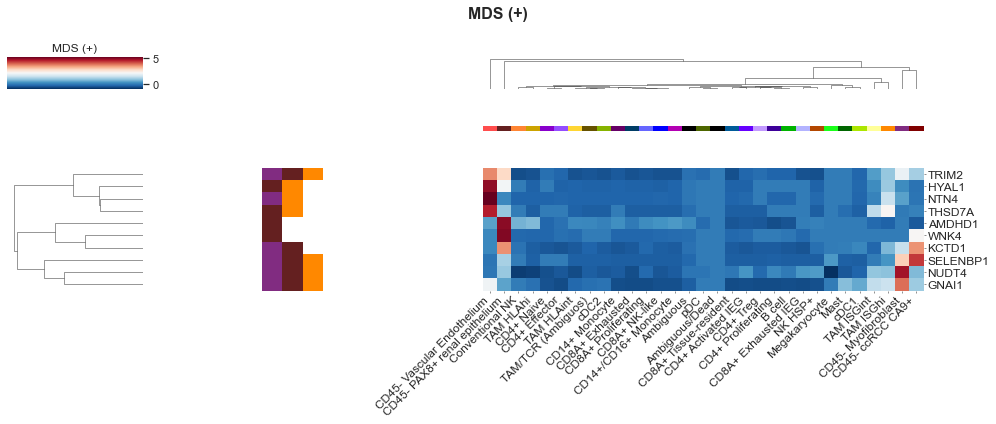

In [25]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

# Now use these two to make heatmap for each regulatory cluster
import matplotlib.pyplot as plt

cols = [c for c in sig_cell_expr_df.columns if c not in ['GeneId', 'GeneName', 'RegulatoryCluster', 'SigCellCluster', 'ID']]
row_links = {}

for reg_label in new_df.RegulatoryCluster.unique():
    # Do a heatmap
    heat_df = new_df[new_df.RegulatoryCluster == reg_label]
    vals = heat_df[cols]
    row_linkage, col_linkage = (hc.linkage(sp.distance.pdist(x), method='average')
                for x in (vals.values, vals.values.T))
    row_links[reg_label] = row_linkage
    print(len(heat_df), len(row_linkage[:, 0]))
    row_colours = [[] for c in heat_df.SigCellCluster.unique()]
    for c in heat_df.SigCellCluster.values:
        cell_types = [x.split('_')[1] for x in c.split('|')]
        for i in range(0, len(row_colours)):
            if i >= len(cell_types):
                row_colours[i].append('white')
            else:
                row_colours[i].append(cell_colours[cell_types[i]])
    # Need to work out for these guys how many unique cell types there are
    col_colours = [cell_colours[c] for c in cols]
    
    if len(heat_df) > 0:
        figsize = (14, int(len(heat_df)/1.5))
        vis_opts = {'figsize': figsize, 'axis_font_size': 12, 'label_font_size': 12, 'title_font_size': 16}
        
        
        vis = Heatmap(heat_df, cols, 'GeneName', config=vis_opts, title=reg_label,
                      row_colours=row_colours, col_colours=col_colours, annot=False)
        vis.plot()
        plt.savefig(f'{output_dir}{run_label}_{reg_label}_heatmap.svg')
        plt.show()

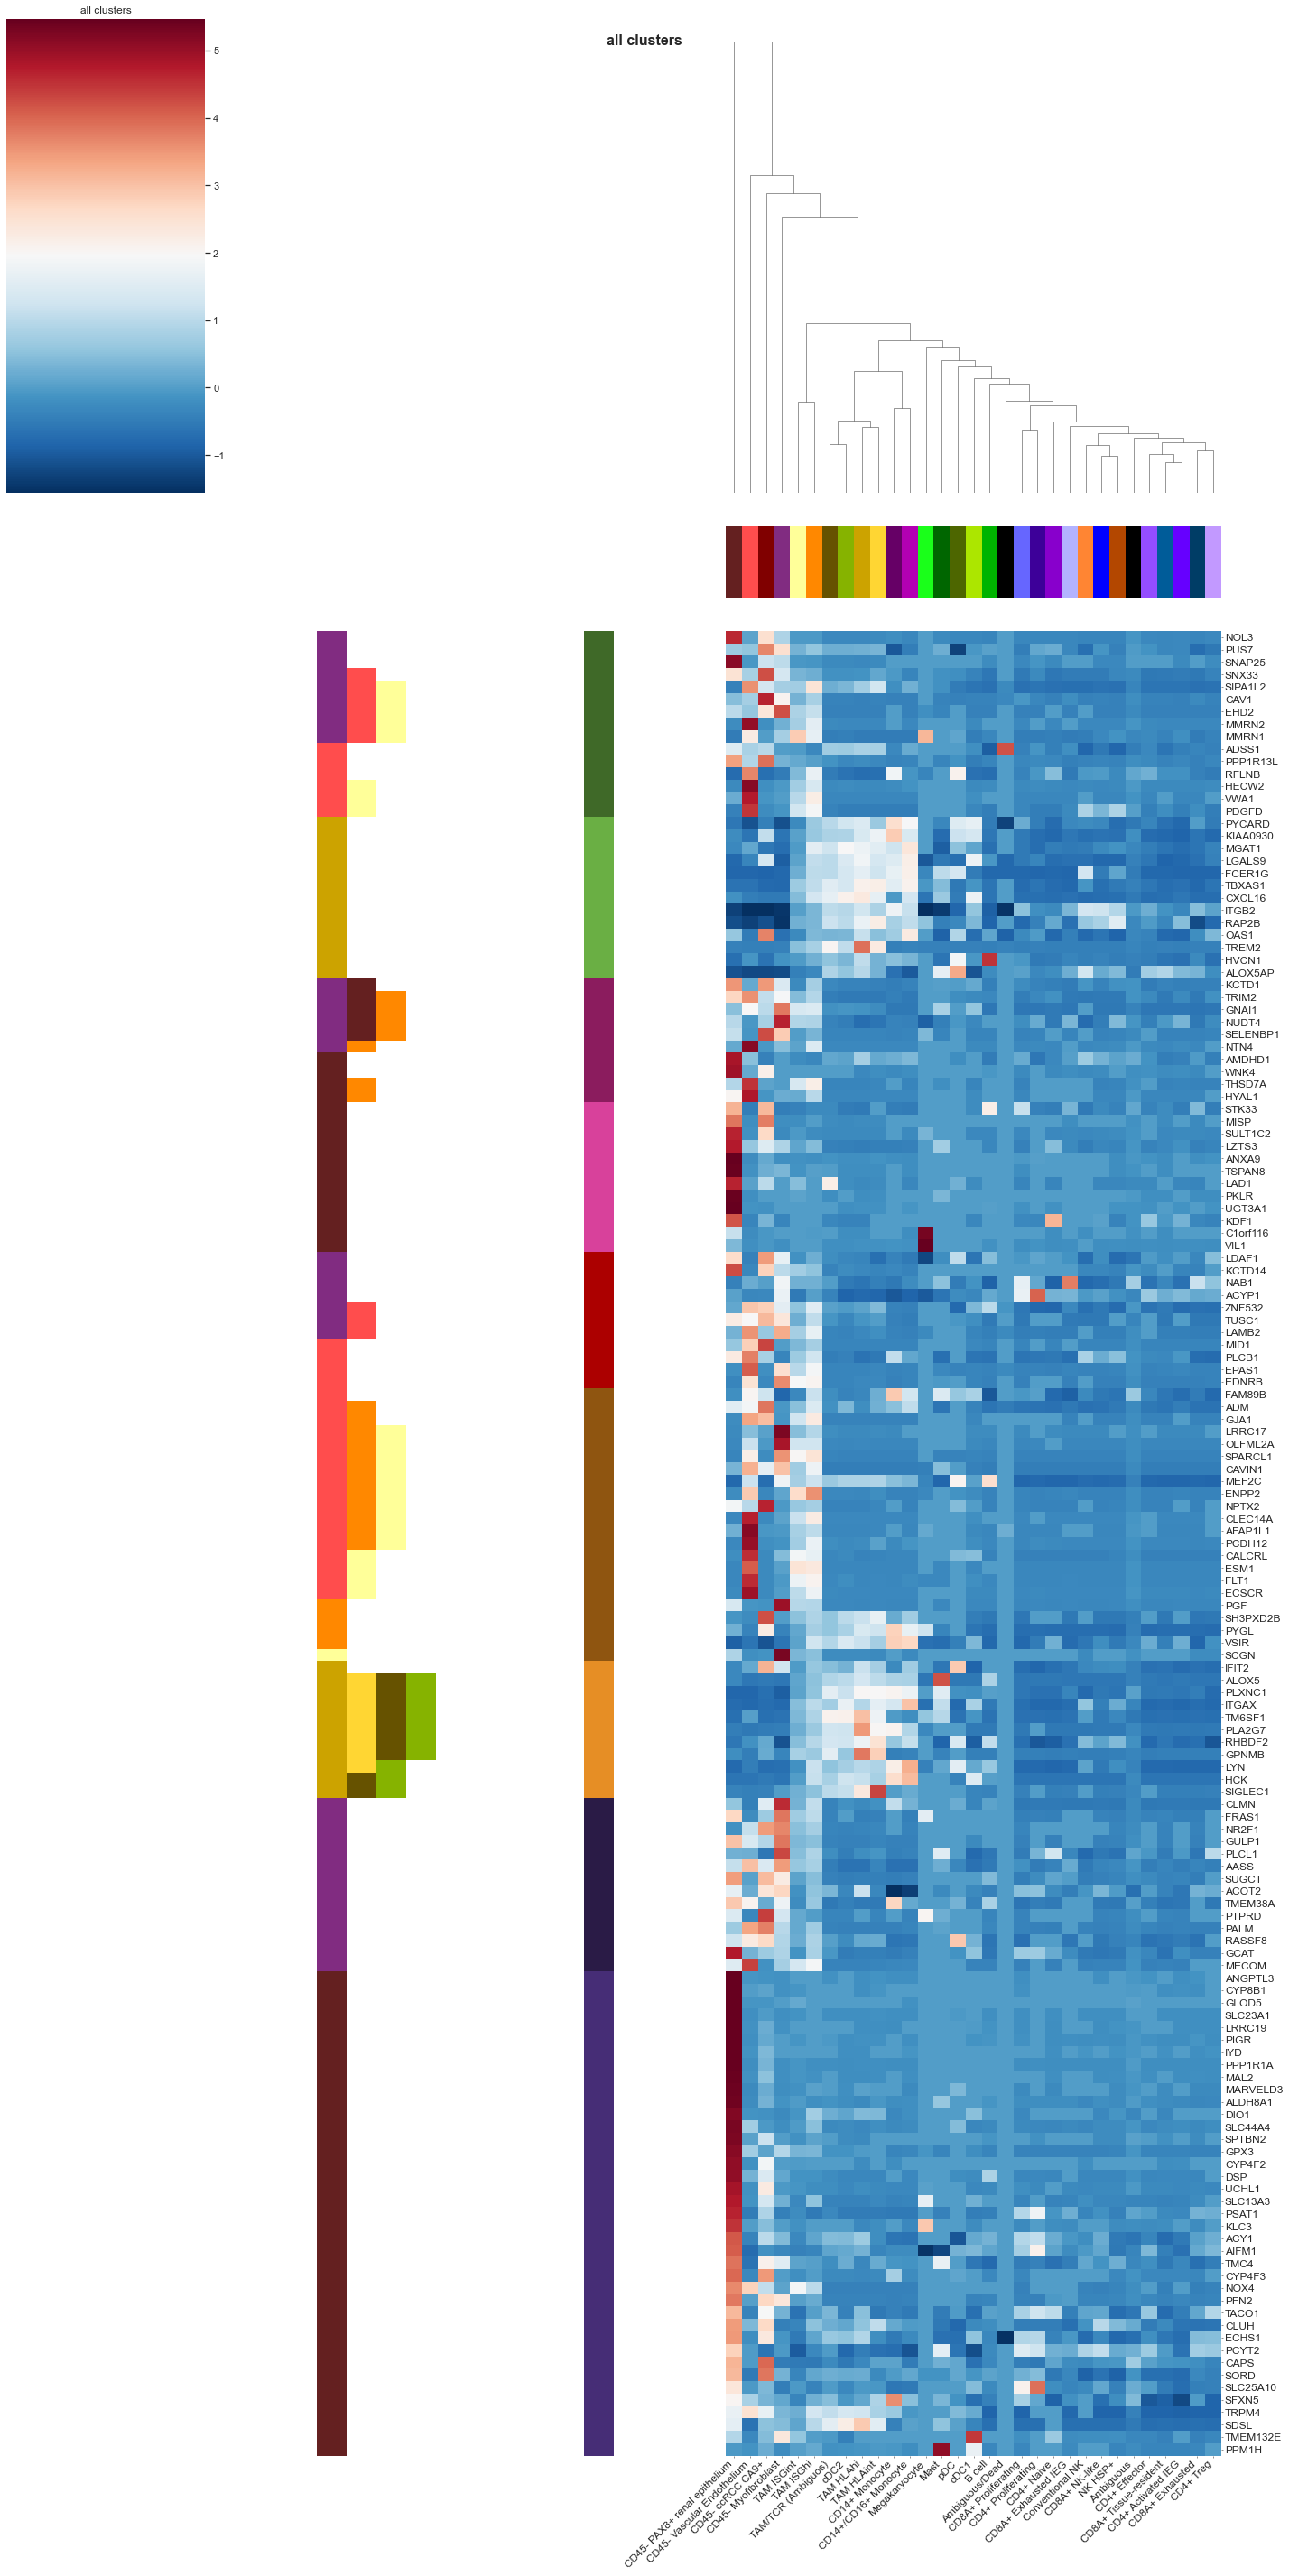

In [184]:
from colormap import rgb2hex, rgb2hls, hls2rgb

colour_map = { 'MDS': '#d8419b', 'MDS_TMDE': '#e585c0', 'MDS_ncRNA': '#d880b4',
               'MDE': '#6aaf44', 'MDE_TMDS': '#0e8e6d', 'MDE_ncRNA': '#9edb77',
               'TMDE': '#fe2323', 'TMDS': '#2952ff',
               'TPDE': '#e68e25', 'TPDE_TMDS': '#844c0f',
                'TPDS': '#462d76', 'TPDS_TMDE': '#9b29b7'}

def hex_to_rgb(colour):
    colour = colour.lstrip('#')
    hlen = len(colour)
    return tuple(int(colour[i:i+hlen//3], 16) for i in range(0, hlen, hlen//3))

def adjust_color_lightness(r, g, b, factor):
    h, l, s = rgb2hls(r / 255.0, g / 255.0, b / 255.0)
    l = max(min(l * factor, 1.0), 0.0)
    r, g, b = hls2rgb(h, l, s)
    return rgb2hex(int(r * 255), int(g * 255), int(b * 255))

def darken_color(r, g, b, factor=0.1):
    return adjust_color_lightness(r, g, b, 1 - factor)

# Do a heatmap
vis_opts = {'figsize': (20, 40), 'axis_font_size': 12, 'label_font_size': 12, 'title_font_size': 16}
cols = [c for c in sig_cell_expr_df.columns if c not in ['GeneId', 'GeneName', 'RegulatoryCluster', 'SigCellCluster', 'ID']]
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist



heat_df = new_df.copy()
links = []
# Do a heatmap
ordering = []

for reg_label in new_df.RegulatoryCluster.unique():
    # Do a heatmap
    r_df = new_df[new_df.RegulatoryCluster == reg_label]
    ranks = squareform(pdist(r_df.loc[:, cols]))
    ordering += list(ranks[:, 0])
    
heat_df['dist'] = ordering                                      
heat_df = heat_df.sort_values(['RegulatoryCluster', 'SigCellCluster', 'dist'],
                              ascending=[True, True, True])

reg_label_colours = []

for c in heat_df.RegulatoryCluster.values:
    colour = colour_map[c.split(' ')[0]]
    if '+' in c:
        r, g, b = hex_to_rgb(colour)
        colour = f'{darken_color(r, g, b, 0.4)}'
    reg_label_colours.append(colour)


cell_types = []
for c in heat_df.SigCellCluster.values:
    cell_types += [x.split('_')[1] for x in c.split('|')]
cell_types = list(set(cell_types))
row_colours = [[] for c in cell_types]
for c in heat_df.SigCellCluster.values:
    cell_types = [x.split('_')[1] for x in c.split('|')]
    for i in range(0, len(row_colours)):
        if i >= len(cell_types):
            row_colours[i].append('white')
        else:
            row_colours[i].append(cell_colours[cell_types[i]])
row_colours.append(reg_label_colours)
# Need to work out for these guys how many unique cell types there are
col_colours = [cell_colours[c] for c in cols]

if len(heat_df) > 0:

    vis = Heatmap(heat_df, cols, 'GeneName', config=vis_opts, title="all clusters", cluster_rows=False,
                  col_colours=col_colours, row_colours=row_colours)
    vis.plot()
    #plt.savefig(f'{output_dir}{run_label}_all_gene_cluster.svg')
    plt.show()

In [27]:
# Create a UMAP DF for visualisations
umap_df = pd.DataFrame()
umap_df.index = data_sub_regulatory.obs.index.values
umap_df['UMAP 1'] =  data_sub_regulatory.obs.UMAP1
umap_df['UMAP 2'] =  data_sub_regulatory.obs.UMAP2
umap_df['Cell Type'] =  data_sub_regulatory.obs.cluster_name

# Add a colours into the plotting
colours = [cell_colours.get(c) for c in data_sub_regulatory.obs.cluster_name.values]
data_sub_regulatory.uns['cluster_name_colors'] = colours

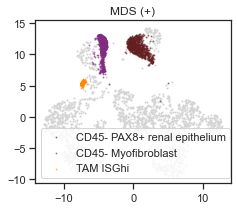

/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_57325/2650541773.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_umap['Mean expr'] = mean_expr[top_expressed_cells]


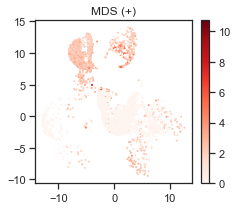

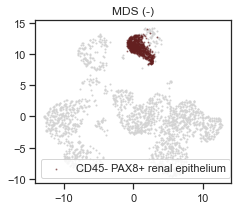

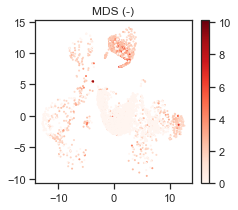

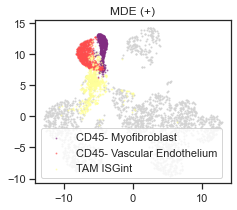

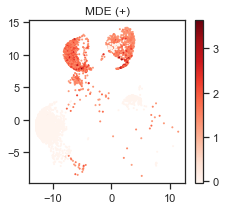

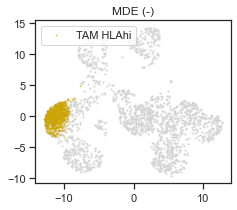

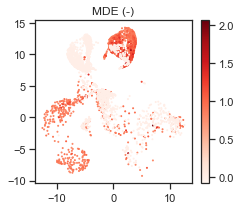

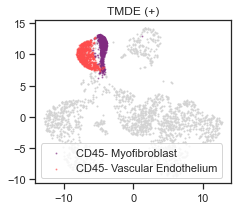

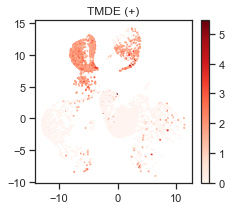

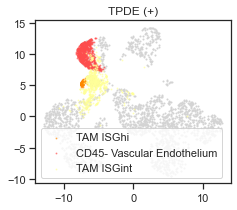

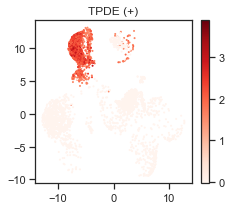

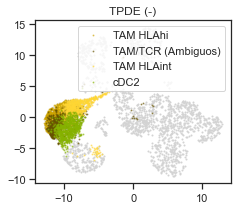

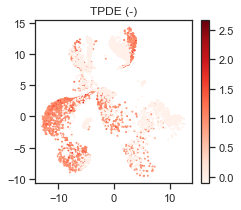

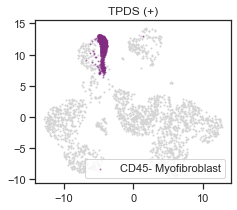

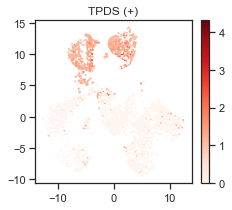

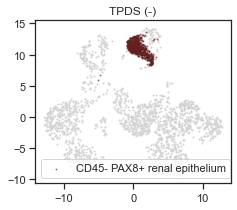

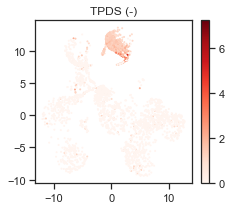

In [178]:
##### Plotting the significant cases
labels = []
cols = [c for c in reg_df.columns if c not in ['GeneName', 'RegulatoryCluster', 'SigCellCluster']]
plt.rcParams["figure.figsize"] = (3.5,3)
for i, reg_label in enumerate(new_df.RegulatoryCluster.unique()):
    r_df =  new_reg_df[new_reg_df.RegulatoryCluster == reg_label]
    genes = r_df.RegulatoryCluster.index.values
    mean_expr = np.nanmean(r_df.loc[genes, cols], axis=0) # Mean expression along the cell types
    
    data_sub_regulatory.obs[f'{reg_label}'] = mean_expr
    cell_types = []
    for c in r_df.SigCellCluster.unique():
        c = c.split('|')
        for sx in c:
            if len(sx.split('_')) > 1:
                cell_types.append(sx.split('_')[1])
    cell_types = list(set(cell_types))

    ### Plotting cell type location on umap, scores on umap, and violin plot of scores across cts
    cell_umap = umap_df[~umap_df['Cell Type'].isin(c)].sample(n=2000)
    plt.scatter(cell_umap['UMAP 1'].values, cell_umap['UMAP 2'].values, c='lightgrey', alpha=1.0, s=1)
    for c in cell_types:
        cell_umap = umap_df[umap_df['Cell Type'] == c]
        if len(cell_umap) > 800:
            cell_umap = cell_umap.sample(n=800)
        plt.scatter(cell_umap['UMAP 1'].values, cell_umap['UMAP 2'].values, c=cell_colours.get(c), 
                        label=c, alpha=0.5, s=1)
    plt.title(reg_label)
    plt.legend()
    plt.savefig(f'{output_dir}{run_label}_{reg_label}_clusters.svg')

    plt.show()

    top_expressed_cells = list(np.argpartition(mean_expr, -2000)[-2000:])
    top_expressed_cells += list(np.argpartition(mean_expr, 2000)[:2000])

    cell_umap = umap_df.iloc[top_expressed_cells,:]
    cell_umap['Mean expr'] = mean_expr[top_expressed_cells]
    x = plt.scatter(cell_umap['UMAP 1'].values, cell_umap['UMAP 2'].values, c=cell_umap['Mean expr'].values, 
                        alpha=1.0, s=1, cmap='Reds')
    plt.colorbar()
    plt.title(reg_label)
    plt.savefig(f'{output_dir}{run_label}_{reg_label}_scatter-mean_nocolourbar.svg')

    plt.show()
    

In [40]:
##### Plotting the significant cases
gene_ids = sig_odds_ratio_df['gene_ids'].values
cell_types = sig_odds_ratio_df['Cell type'].values
labels = []
for i, reg_label in enumerate(sig_odds_ratio_df['Regulatory Cluster label'].values):
    genes = gene_ids[i].split(' ')
    mean_expr = np.nanmean(df.loc[genes], axis=0) # Mean expression along the cell types
    data_sub_regulatory.obs[f'{reg_label}_{cell_types[i]}'] = mean_expr
    labels.append(f'{reg_label}_{cell_types[i]}') #Keep track of the labels
#     ### Plotting cell type location on umap, scores on umap, and violin plot of scores across cts
#     fig, axes = plt.subplots(ncols=2, figsize=(20,5))
#     sc.pl.umap(data_sub_regulatory, color='cluster_name',
#                groups=[cell_types[i]],
#                ax=axes[0], show=False, legend_loc=None)
#     axes[0].set_title(reg_label)
#     # Get the mean across these genes
#     sc.pl.umap(data_sub_regulatory, color=f'{reg_label}_{cell_types[i]}', 
#                ax=axes[1], show=True, cmap='Reds', vmin=0, vmax=0.5)    
#     sc.pl.heatmap(data_sub_regulatory, var_names=genes, groupby='cluster_name', swap_axes=True,
#                  vmin=0, vmax=2.0, dendrogram=True) #, ax=axes[2])
    #sc.pl.stacked_violin(data_sub_regulatory, genes, groupby='cluster_name', ax=axes[2], dendrogram=True)
#     sc.pl.violin(data_sub_regulatory, keys=reg_label,
#                      groupby='cluster_name', rotation=90, ax=axes[2], show=True) 

## Do a dendogram and check these clusters align with what we saw before

['MDS (+)_CD45- Myofibroblast', 'TPDS (+)_CD45- Myofibroblast', 'MDS (+)_CD45- PAX8+ renal epithelium', 'TPDS (-)_CD45- PAX8+ renal epithelium', 'MDS (-)_CD45- PAX8+ renal epithelium', 'MDE (+)_CD45- Vascular Endothelium', 'TMDE (+)_CD45- Vascular Endothelium', 'TPDE (+)_CD45- Vascular Endothelium', 'TMDE (+)_CD45- Myofibroblast', 'MDS (+)_TAM ISGhi', 'MDE (+)_CD45- Myofibroblast', 'MDE (+)_TAM ISGint', 'TPDE (+)_TAM ISGhi', 'TPDE (+)_TAM ISGint', 'MDE (-)_TAM HLAhi', 'TPDE (-)_TAM HLAhi', 'TPDE (-)_TAM HLAint', 'TPDE (-)_TAM/TCR (Ambiguos)', 'TPDE (-)_cDC2']


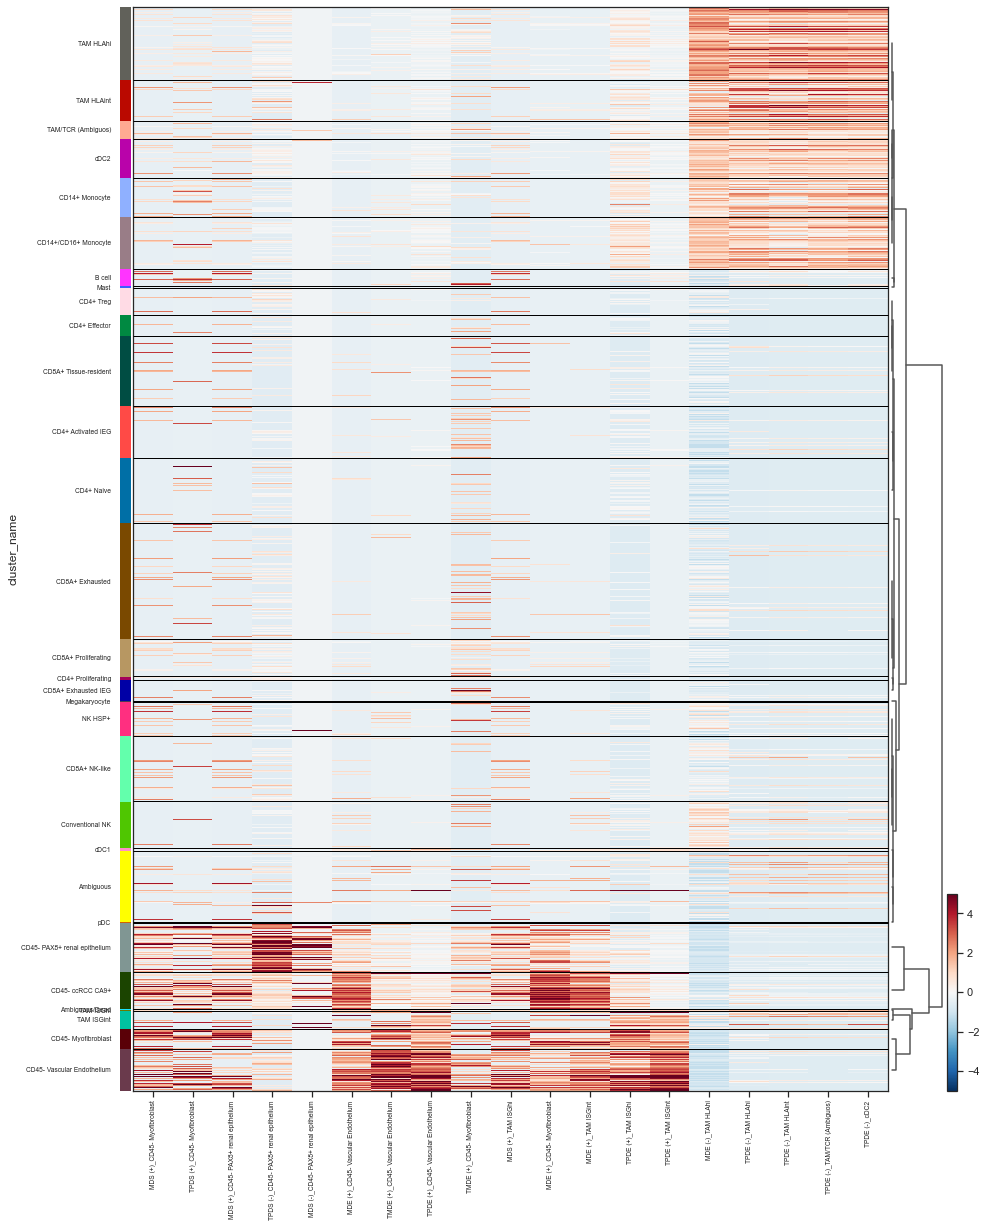

In [41]:
new_vars = ['MDS (+)_CD45- Myofibroblast',             
            'TPDS (+)_CD45- Myofibroblast',
            
            'MDS (+)_CD45- PAX8+ renal epithelium', 
            'TPDS (-)_CD45- PAX8+ renal epithelium',
            'MDS (-)_CD45- PAX8+ renal epithelium', 
            'MDE (+)_CD45- Vascular Endothelium', 
            'TMDE (+)_CD45- Vascular Endothelium', 
            'TPDE (+)_CD45- Vascular Endothelium', 
            
            'TMDE (+)_CD45- Myofibroblast', 
            
            'MDS (+)_TAM ISGhi',
            
            'MDE (+)_CD45- Myofibroblast', 
            'MDE (+)_TAM ISGint', 
           
            
            'TPDE (+)_TAM ISGhi', 
            'TPDE (+)_TAM ISGint', 
            
             'MDE (-)_TAM HLAhi', 
            'TPDE (-)_TAM HLAhi', 
            'TPDE (-)_TAM HLAint', 
            'TPDE (-)_TAM/TCR (Ambiguos)', 
            'TPDE (-)_cDC2',
            ]
rest_info = [col for col in data_sub_regulatory.obs.columns if col not in new_vars]
print(new_vars)
#### AnnData where instead of gene expression values, we have module scores per cell
score_data = sc.AnnData(data_sub_regulatory.obs.loc[:,new_vars], 
                        obs=data_sub_regulatory.obs.loc[:,rest_info], obsm=data_sub_regulatory.obsm)
score_data.layers['scaled'] = sc.pp.scale(score_data, copy=True).X
sc.tl.dendrogram(score_data, use_rep='X', groupby='cluster_name')

### Heatmap of scores per cell, grouped by cell type, with cell types grouped by distance with above dendrogram
sc.pl.heatmap(score_data, score_data.var_names.values, groupby='cluster_name', layer='scaled',
             vmin=-5, 
              vmax=5, 
              dendrogram=True, cmap='RdBu_r', figsize=(15,20),
              show=False,
             )
plt.savefig(f'{output_dir}{run_label}_scanpy_heatmap.svg')
plt.show()

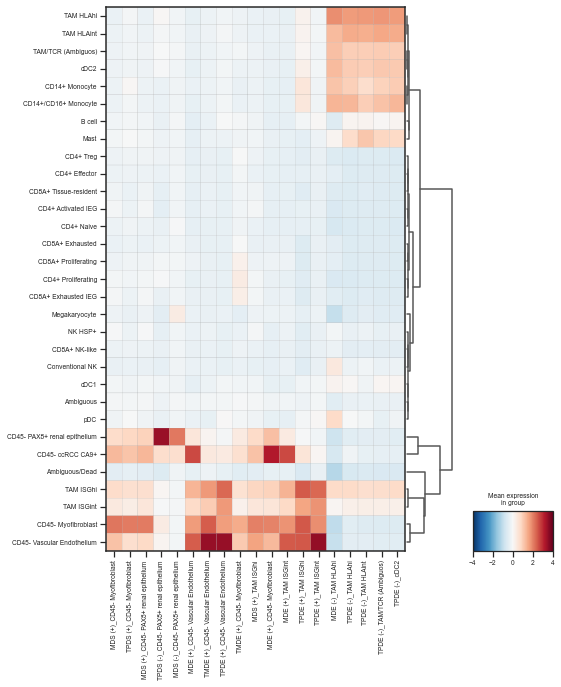

In [42]:
#### Equivalent to above but is averaged per cell type
sc.pl.matrixplot(score_data, score_data.var_names.values, groupby='cluster_name', layer='scaled',
             vmin=-4, 
              vmax=4, 
              dendrogram=True, cmap='RdBu_r', figsize=(8,10),
              show=False
             )
plt.savefig(f'{output_dir}{run_label}_scanpy_matrixplt.svg')


In [43]:
ens_name_map = dict(zip(integrated_df.hgnc_symbol, integrated_df.id))


In [179]:
# # only plot genes once
# from collections import defaultdict
# from sciutil import SciUtil

# u = SciUtil()
# gene_map = gene_name_map
# cond1 = run_label.split('-')[0]
# cond0 = run_label.split('-')[1]
# for i, gene_name in enumerate(['EPAS1', 'FLT1', 'LGALS9']):
#     #if not seen_genes.get(ensembl_id):
#     ensembl_id = ens_name_map[gene_name]
#     plot_gene(ensembl_id, cond0, cond1, x="Tumor Stage", cmap='Reds', label=f'')

In [47]:
sig_odds_ratio_df['Cell type'].unique()

array(['CD45- Myofibroblast', 'CD45- PAX8+ renal epithelium', 'TAM ISGhi',
       'CD45- Vascular Endothelium', 'TAM ISGint', 'TAM HLAhi',
       'TAM HLAint', 'TAM/TCR (Ambiguos)', 'cDC2'], dtype=object)

In [93]:

   
import collections.abc as cabc
from copy import copy
import numpy as np
import pandas as pd
from cycler import Cycler
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import Normalize
from matplotlib import pyplot as pl
from matplotlib import rcParams, cm
from anndata import AnnData
from typing import Union, Optional, List, Sequence, Iterable, Mapping

from matplotlib.colors import Colormap
from scanpy.get import obs_df


def _rank_genes_groups_plot(
    adata: AnnData,
    plot_type: str = 'heatmap',
    groups: Union[str, Sequence[str]] = None,
    n_genes: Optional[int] = None,
    groupby: Optional[str] = None,
    values_to_plot: Optional[str] = None,
    var_names: Optional[Union[Sequence[str], Mapping[str, Sequence[str]]]] = None,
    min_logfoldchange: Optional[float] = None,
    key: Optional[str] = None,
    show: Optional[bool] = None,
    save: Optional[bool] = None,
    return_fig: Optional[bool] = False,
    gene_symbols: Optional[str] = None,
    **kwds,
):
    """\
    Common function to call the different rank_genes_groups_* plots
    """
    if var_names is not None and n_genes is not None:
        raise ValueError(
            "The arguments n_genes and var_names are mutually exclusive. Please "
            "select only one."
        )

    if var_names is None and n_genes is None:
        # set n_genes = 10 as default when none of the options is given
        n_genes = 10

    if key is None:
        key = 'rank_genes_groups'

    if groupby is None:
        groupby = str(adata.uns[key]['params']['groupby'])
    group_names = adata.uns[key]['names'].dtype.names if groups is None else groups

    if var_names is not None:
        if isinstance(var_names, Mapping):
            # get a single list of all gene names in the dictionary
            var_names_list = sum([list(x) for x in var_names.values()], [])
        elif isinstance(var_names, str):
            var_names_list = [var_names]
        else:
            var_names_list = var_names
    else:
        # dict in which each group is the key and the n_genes are the values
        var_names = {}
        var_names_list = []
        for group in group_names:
            df = rank_genes_groups_df(
                adata,
                group,
                key=key,
                gene_symbols=gene_symbols,
                log2fc_min=min_logfoldchange,
            )

            if gene_symbols is not None:
                df['names'] = df[gene_symbols]

            genes_list = df.names[df.names.notnull()].tolist()

            if len(genes_list) == 0:
                logg.warning(f'No genes found for group {group}')
                continue
            if n_genes < 0:
                genes_list = genes_list[n_genes:]
            else:
                genes_list = genes_list[:n_genes]
            var_names[group] = genes_list
            var_names_list.extend(genes_list)

    # by default add dendrogram to plots
    #kwds.setdefault('dendrogram', True)

    if plot_type in ['dotplot', 'matrixplot']:
        # these two types of plots can also
        # show score, logfoldchange and pvalues, in general any value from rank
        # genes groups
        title = None
        values_df = None
        if values_to_plot is not None:
            values_df = _get_values_to_plot(
                adata,
                values_to_plot,
                var_names_list,
                key=key,
                gene_symbols=gene_symbols,
            )
            title = values_to_plot
            if values_to_plot == 'logfoldchanges':
                title = 'log fold change'
            else:
                title = values_to_plot.replace("_", " ").replace('pvals', 'p-value')

        if plot_type == 'dotplot':
            from .._dotplot import dotplot

            _pl = dotplot(
                adata,
                var_names,
                groupby,
                dot_color_df=values_df,
                return_fig=True,
                gene_symbols=gene_symbols,
                **kwds,
            )
            if title is not None and 'colorbar_title' not in kwds:
                _pl.legend(colorbar_title=title)
        elif plot_type == 'matrixplot':
            from .._matrixplot import matrixplot

            _pl = matrixplot(
                adata,
                var_names,
                groupby,
                values_df=values_df,
                return_fig=True,
                gene_symbols=gene_symbols,
                **kwds,
            )

            if title is not None and 'colorbar_title' not in kwds:
                _pl.legend(title=title)

        return _fig_show_save_or_axes(_pl, return_fig, show, save)

    elif plot_type == 'stacked_violin':
        from .._stacked_violin import stacked_violin

        _pl = stacked_violin(
            adata,
            var_names,
            groupby,
            return_fig=True,
            gene_symbols=gene_symbols,
            **kwds,
        )
        return _fig_show_save_or_axes(_pl, return_fig, show, save)
    elif plot_type == 'heatmap':
        from .._anndata import heatmap

        return heatmap(
            adata,
            var_names,
            groupby,
            show=show,
            save=save,
            gene_symbols=gene_symbols,
            **kwds,
        )

    elif plot_type == 'tracksplot':
        from .._anndata import tracksplot

        return tracksplot(
            adata,
            var_names,
            groupby,
            show=show,
            save=save,
            gene_symbols=gene_symbols,
            **kwds,
        )
    
def rank_genes_groups_dotplot(
    adata: AnnData,
    groups: Union[str, Sequence[str]] = None,
    n_genes: Optional[int] = None,
    groupby: Optional[str] = None,
    values_to_plot: Optional[str] = None,
    var_names: Optional[Union[Sequence[str], Mapping[str, Sequence[str]]]] = None,
    gene_symbols: Optional[str] = None,
    min_logfoldchange: Optional[float] = None,
    key: Optional[str] = None,
    show: Optional[bool] = None,
    save: Optional[bool] = None,
    return_fig: Optional[bool] = False,
    **kwds,
):
    return _rank_genes_groups_plot(
        adata,
        plot_type='dotplot',
        groups=groups,
        n_genes=n_genes,
        groupby=groupby,
        values_to_plot=values_to_plot,
        var_names=var_names,
        gene_symbols=gene_symbols,
        key=key,
        min_logfoldchange=min_logfoldchange,
        show=show,
        save=save,
        return_fig=return_fig,
        **kwds,
    )



def _get_values_to_plot(
    adata,
    values_to_plot: [
        'scores',
        'logfoldchanges',
        'pvals',
        'pvals_adj',
        'log10_pvals',
        'log10_pvals_adj',
    ],
    gene_names: Sequence[str],
    groups: Optional[Sequence[str]] = None,
    key: Optional[str] = 'rank_genes_groups',
    gene_symbols: Optional[str] = None,
):
    """
    If rank_genes_groups has been called, this function
    prepares a dataframe containing scores, pvalues, logfoldchange etc to be plotted
    as dotplot or matrixplot.
    The dataframe index are the given groups and the columns are the gene_names
    used by rank_genes_groups_dotplot
    Parameters
    ----------
    adata
    values_to_plot
        name of the value to plot
    gene_names
        gene names
    groups
        groupby categories
    key
        adata.uns key where the rank_genes_groups is stored.
        By default 'rank_genes_groups'
    gene_symbols
        Key for field in .var that stores gene symbols.
    Returns
    -------
    pandas DataFrame index=groups, columns=gene_names
    """
    valid_options = [
        'scores',
        'logfoldchanges',
        'pvals',
        'pvals_adj',
        'log10_pvals',
        'log10_pvals_adj',
    ]
    if values_to_plot not in valid_options:
        raise ValueError(
            f"given value_to_plot: '{values_to_plot}' is not valid. Valid options are {valid_options}"
        )

    values_df = None
    check_done = False
    if groups is None:
        groups = adata.uns[key]['names'].dtype.names
    if values_to_plot is not None:

        df_list = []
        for group in groups:
            df = rank_genes_groups_df(adata, group, key=key, gene_symbols=gene_symbols)
            if gene_symbols is not None:
                df['names'] = df[gene_symbols]
            # check that all genes are present in the df as sc.tl.rank_genes_groups
            # can be called with only top genes
            if not check_done:
                if df.shape[0] < adata.shape[1]:
                    message = (
                        "Please run `sc.tl.rank_genes_groups` with "
                        "'n_genes=adata.shape[1]' to save all gene "
                        f"scores. Currently, only {df.shape[0]} "
                        "are found"
                    )
                    logg.error(message)
                    raise ValueError(message)
            df['group'] = group
            df_list.append(df)

        values_df = pd.concat(df_list)
        if values_to_plot.startswith('log10'):
            column = values_to_plot.replace('log10_', '')
        else:
            column = values_to_plot
        values_df = pd.pivot(
            values_df, index='names', columns='group', values=column
        ).fillna(1)

        if values_to_plot in ['log10_pvals', 'log10_pvals_adj']:
            values_df = -1 * np.log10(values_df)

        values_df = values_df.loc[gene_names].T

    return values_df

categories: Ambiguous, Ambiguous/Dead, B cell, etc.
var_group_labels: MDS (+), MDE (+), TMDE (+), etc.


KeyError: 'CD4+ Proliferating'

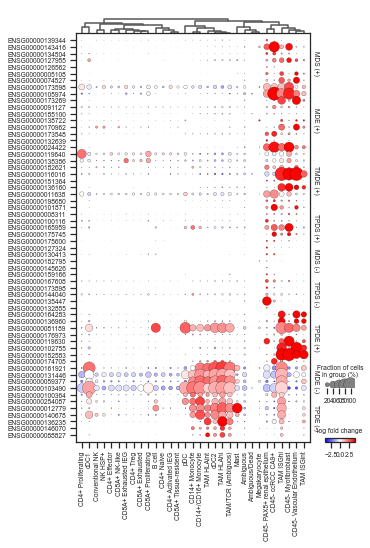

In [98]:

# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html
categories_order={'All': list(plotting_gene_map.keys()), 'TPDE': ['TPDE (+)', 'TPDE (-)']}
for cat in categories_order:
    plt_plotting_gene_map = {k:plotting_gene_map[k] for k in categories_order[cat]}
    fig, ax = plt.subplots(figsize=(5,8))
    dpl = sc.pl.rank_genes_groups_dotplot(
        data_sub_regulatory, # This is the ranking we created earlier
        var_names=plt_plotting_gene_map,
        values_to_plot="logfoldchanges",
        cmap='bwr',
        vmin=-4,
        vmax=4,
        min_logfoldchange=3,
        colorbar_title='log fold change',
        show = False, 
        ax=ax,
        swap_axes=True,
        categories_order=list(cat_order.keys()),
        return_fig=True
    )
    ax_all = dpl.get_axes()
    ax = ax_all['mainplot_ax']
    # Rename to gene names
    labels = [f'{gene_name_map.get(item.get_text())}: {round(gene_padj_map[item.get_text()], 2)}' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    # Rename the ensembl gene IDs to the gene name 
    if save_figs:
        plt.savefig(f'{output_dir}{run_label}_{cat}_rank_cell-types.svg')
    plt.show()

        
        

In [ ]:
?rank_genes_groups_dotplot

In [78]:
sc.tl.filter_rank_genes_groups(data_sub_regulatory,
                               min_in_group_fraction=0.5,
                               max_out_group_fraction=0.3,
                               min_fold_change=1.0)

categories: Ambiguous, Ambiguous/Dead, B cell, etc.
var_group_labels: MDS (+), MDE (+), TMDE (+), etc.


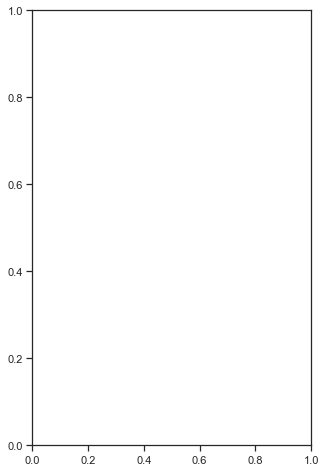

KeyboardInterrupt: 

In [79]:
#sc.pl.rank_genes_groups_tracksplot(data_sub_regulatory, n_genes=6, key='rank_genes_groups_filtered')

# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html
categories_order={'All': list(plotting_gene_map.keys()), 'TPDE': ['TPDE (+)', 'TPDE (-)']}
for cat in categories_order:
    plt_plotting_gene_map = {k:plotting_gene_map[k] for k in categories_order[cat]}
    fig, ax = plt.subplots(figsize=(5,8))
    dpl = sc.pl.rank_genes_groups_tracksplot(
        data_sub_regulatory, # This is the ranking we created earlier
        var_names=plt_plotting_gene_map,
        values_to_plot="logfoldchanges",
        cmap='bwr',
        vmin=-4,
        vmax=4,
        key='rank_genes_groups_filtered',
        min_logfoldchange=3,
        colorbar_title='log fold change',
        show = False, 
        ax=ax,
        categories_order=list(cat_order.keys()),
        return_fig=True
    )
    #ax_all = dpl.get_axes()
#     ax = ax_all['mainplot_ax']
#     # Rename to gene names
#     labels = [f'{gene_name_map.get(item.get_text())}: {round(gene_padj_map[item.get_text()], 2)}' for item in ax.get_xticklabels()]
#     ax.set_xticklabels(labels)
    # Rename the ensembl gene IDs to the gene name 
    if save_figs:
        plt.savefig(f'{output_dir}{run_label}_{cat}_rank_cell-types.svg')
    plt.show()

        
        

categories: Ambiguous, Ambiguous/Dead, B cell, etc.
var_group_labels: MDS (+), MDE (+), TMDE (+), etc.


{'track_axes': [<AxesSubplot:ylabel='ENSG00000139344'>,
  <AxesSubplot:ylabel='ENSG00000143416'>,
  <AxesSubplot:ylabel='ENSG00000134504'>,
  <AxesSubplot:ylabel='ENSG00000127955'>,
  <AxesSubplot:ylabel='ENSG00000126562'>,
  <AxesSubplot:ylabel='ENSG00000005108'>,
  <AxesSubplot:ylabel='ENSG00000074527'>,
  <AxesSubplot:ylabel='ENSG00000173598'>,
  <AxesSubplot:ylabel='ENSG00000105974'>,
  <AxesSubplot:ylabel='ENSG00000173269'>,
  <AxesSubplot:ylabel='ENSG00000091127'>,
  <AxesSubplot:ylabel='ENSG00000185100'>,
  <AxesSubplot:ylabel='ENSG00000138722'>,
  <AxesSubplot:ylabel='ENSG00000170962'>,
  <AxesSubplot:ylabel='ENSG00000173548'>,
  <AxesSubplot:ylabel='ENSG00000132639'>,
  <AxesSubplot:ylabel='ENSG00000024422'>,
  <AxesSubplot:ylabel='ENSG00000119640'>,
  <AxesSubplot:ylabel='ENSG00000138386'>,
  <AxesSubplot:ylabel='ENSG00000182621'>,
  <AxesSubplot:ylabel='ENSG00000116016'>,
  <AxesSubplot:ylabel='ENSG00000151364'>,
  <AxesSubplot:ylabel='ENSG00000136160'>,
  <AxesSubplot:ylabe

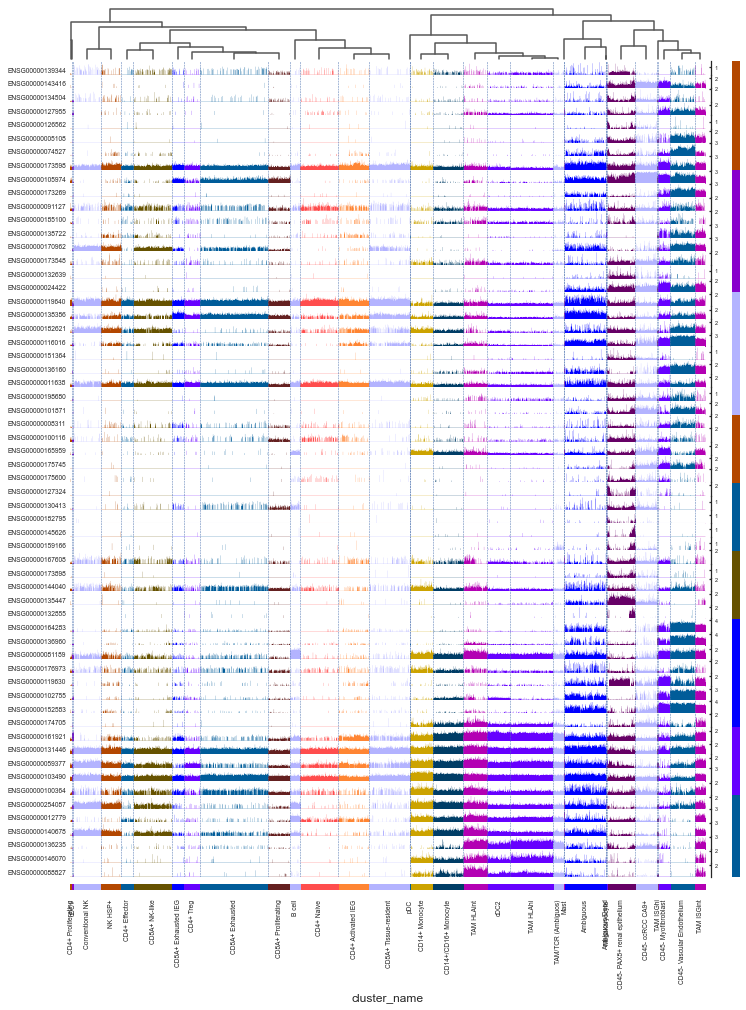

In [82]:
sc.pl.rank_genes_groups_tracksplot(
        data_sub_regulatory, # This is the ranking we created earlier
        values_to_plot="logfoldchanges",
        cmap='bwr',
        vmin=-4,
        vmax=4,
        var_names=plt_plotting_gene_map,
        min_logfoldchange=1.5,
        colorbar_title='log fold change',
        show = False, 
        categories_order=list(cat_order.keys()),
        dendogram=False,
    )

In [66]:
cat_order = dict(zip(data_sub_regulatory.obs.cluster_name, data_sub_regulatory.obs.cluster))

In [67]:
cat_order

{'CD8A+ NK-like': 4,
 'CD8A+ Proliferating': 15,
 'CD8A+ Exhausted IEG': 19,
 'Conventional NK': 10,
 'CD8A+ Tissue-resident': 2,
 'CD45- Vascular Endothelium': 11,
 'NK HSP+': 17,
 'CD4+ Activated IEG': 7,
 'TAM/TCR (Ambiguos)': 18,
 'CD45- PAX8+ renal epithelium': 9,
 'TAM HLAhi': 1,
 'CD8A+ Exhausted': 0,
 'CD14+ Monocyte': 14,
 'CD14+/CD16+ Monocyte': 5,
 'CD45- Myofibroblast': 20,
 'CD4+ Naive': 3,
 'cDC2': 13,
 'TAM HLAint': 12,
 'Ambiguous': 23,
 'Mast': 21,
 'CD4+ Proliferating': 32,
 'CD45- ccRCC CA9+': 16,
 'CD4+ Effector': 31,
 'TAM ISGint': 30,
 'B cell': 22,
 'CD4+ Treg': 6,
 'TAM ISGhi': 27,
 'cDC1': 33,
 'Megakaryocyte': 28,
 'pDC': 34,
 'Ambiguous/Dead': 29}

categories: Ambiguous, Ambiguous/Dead, B cell, etc.
var_group_labels: B cell, CD4+ Naive, CD4+ Proliferating, etc.


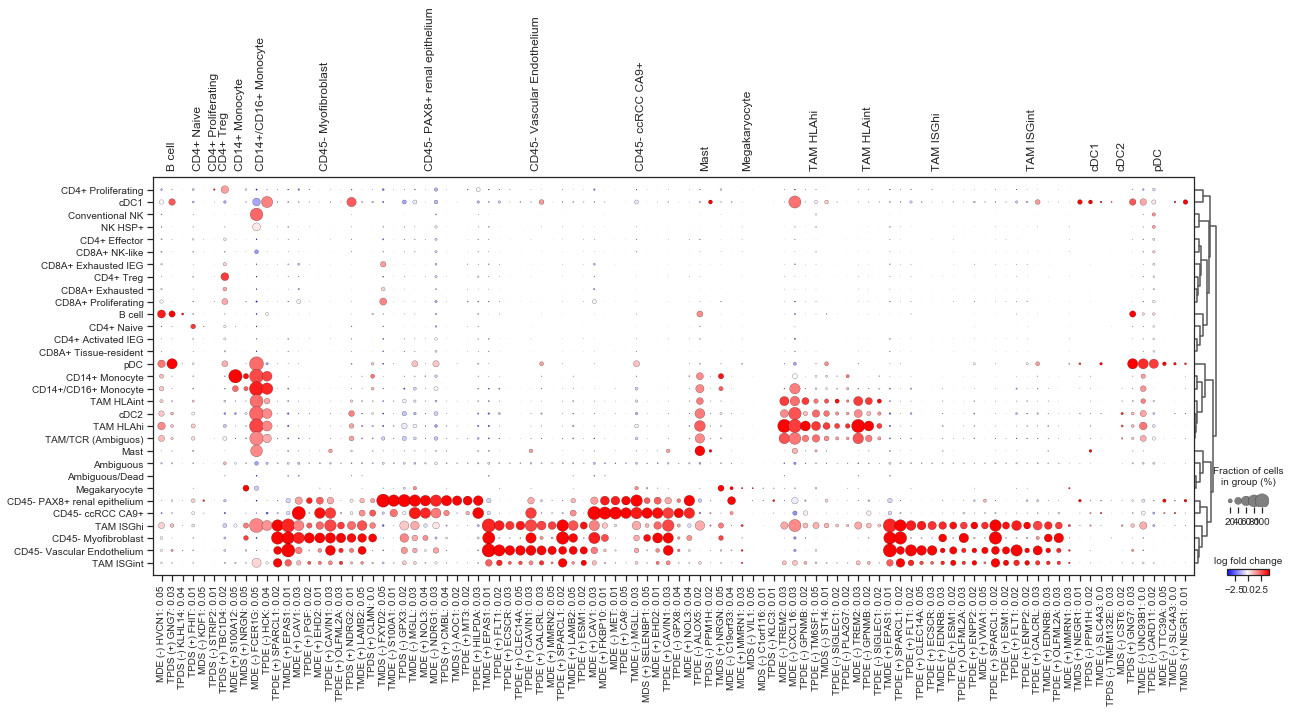

In [200]:

# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html
categories_order={'All': list(plotting_gene_map.keys())}
for cat in categories_order:
    try:
        fig, ax = plt.subplots(figsize=(20,8))
        dpl = sc.pl.rank_genes_groups_dotplot(
            data_sub_regulatory,
            values_to_plot="logfoldchanges",
            cmap='bwr',
            vmin=-4,
            vmax=4,
            min_logfoldchange=3,
            colorbar_title='log fold change',
            show = False, 
            ax=ax,
            return_fig=True
        )
        ax_all = dpl.get_axes()
        ax = ax_all['mainplot_ax']
        # Rename to gene names
        labels = [f'{gene_cluster_map.get(item.get_text())} {gene_name_map.get(item.get_text())}: {round(gene_padj_map[item.get_text()], 2)}' for item in ax.get_xticklabels()]
        ax.set_xticklabels(labels)
        # Rename the ensembl gene IDs to the gene name 
        if save_figs:
            plt.savefig(f'{output_dir}{run_label}_rank_cell-types.svg')
        plt.show()
    except:
        print(cat)
        
        

In [34]:
# Want to also plot the RNA, protein between S1 and S4 and also the protein from the new dataset


###############################################################################
#                                                                             #
#    This program is free software: you can redistribute it and/or modify     #
#    it under the terms of the GNU General Public License as published by     #
#    the Free Software Foundation, either version 3 of the License, or        #
#    (at your option) any later version.                                      #
#                                                                             #
#    This program is distributed in the hope that it will be useful,          #
#    but WITHOUT ANY WARRANTY; without even the implied warranty of           #
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the            #
#    GNU General Public License for more details.                             #
#                                                                             #
#    You should have received a copy of the GNU General Public License        #
#    along with this program. If not, see <http://www.gnu.org/licenses/>.     #
#                                                                             #
###############################################################################
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statannot import add_stat_annotation

from sciviso import Vis


class Boxplot(Vis):
    """
    Box plot. Adds stat annotations and returns the SVG or saves it to disk.
    for stats annotations details see: https://github.com/webermarcolivier/statannot
    """
    def __init__(self, df: pd.DataFrame, x: object, y: object, title='', xlabel='', ylabel='', box_colors=None,
                 hue=None, order=None, hue_order=None, showfliers=False, add_dots=False, add_stats=True,
                 stat_method='Mann-Whitney', box_pairs=None, figsize=(3, 3), title_font_size=12, label_font_size=8,
                 title_font_weight=700, config=None):
        super().__init__(df, figsize=figsize, title_font_size=title_font_size, label_font_size=label_font_size,
                         title_font_weight=title_font_weight)
        self.df = df
        self.x = x
        self.y = y
        self.title = title
        self.hue = hue
        self.order = order
        self.hue_order = hue_order
        self.showfliers = showfliers
        self.add_dots = add_dots
        self.add_stats = add_stats
        self.stat_method = stat_method
        self.box_pairs = box_pairs
        self.label = 'boxplot'
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.box_colors = box_colors
        if config:
            self.load_style(config)

    def format_data_for_boxplot(self, df: pd.DataFrame, conditions: list, filter_column=None, filter_values=None):
        condition_dict = defaultdict(list)
        for column in df.columns:
            for c in conditions:
                if c in column:
                    condition_dict[c].append(column)

        # Now lets get the values
        values = []
        condition = []
        samples = []
        if filter_column is None or filter_values is None:
            for i in range(0, len(df)):
                for cond, columns in condition_dict.items():
                    for c in columns:
                        values.append(df[c].values[i])
                        condition.append(cond)
                        samples.append(c)
        else:
            i = 0
            for v in df[filter_column].values:
                if v in filter_values:
                    for cond, columns in condition_dict.items():
                        for c in columns:
                            values.append(df[c].values[i])
                            condition.append(cond)
                            samples.append(c)
                i += 1
        box_df = pd.DataFrame()
        box_df['Samples'] = samples
        box_df['Values'] = values
        box_df['Conditions'] = condition
        return box_df

    def plot(self, ax=None, legend=True):
        x, y, hue_order, order, hue, box_pairs = self.x, self.y, self.hue_order, self.order, self.hue, self.box_pairs
        # First lets check whether we were passed lists or strings for our y and x arrays
        if not isinstance(x, str) and not isinstance(y, str):
            vis_df = pd.DataFrame()
            vis_df['x'] = x
            vis_df['y'] = y
            x = 'x'
            y = 'y'
            if hue is not None:
                vis_df['colour'] = hue
                hue = 'colour'
            if order is None:
                order = list(set(vis_df['x'].values))
                order.sort()
        else:
            vis_df = self.df

        # set the orders
        if hue_order is None and hue is not None:
            hue_order = list(set(vis_df[hue].values))
            hue_order.sort()
        if order is None:
            order = list(set(vis_df[x].values))
            order.sort()

        ax = sns.boxplot(data=vis_df, x=x, y=y, hue=hue, hue_order=hue_order, order=order, palette=self.palette,
                         showfliers=self.showfliers, ax=ax)
        if self.add_dots:
            ax = sns.swarmplot(data=vis_df, x=x, y=y, hue_order=hue_order, 
                               order=order, hue=hue, dodge=True, alpha=0.3,  ax=ax, palette=['black', 'black'])
            
        if self.add_stats:
            # Add all pairs in the order if the box pairs is none
            if box_pairs is None:
                pairs = []
                box_pairs = []
                for i in order:
                    for j in order:
                        if i != j:
                            # Ensure we don't get duplicates
                            pair = f'{i}{j}' if i < j else f'{j}{i}'
                            if pair not in pairs:
                                box_pairs.append((i, j))
                                pairs.append(pair)
            # Add stats annotation
            add_stat_annotation(ax, data=vis_df, x=x, y=y, order=order,
                                box_pairs=box_pairs,
                                test=self.stat_method, text_format='star', loc='inside', verbose=2)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', weight = 'bold')

        # Check if the user supplied a list of colours for the boxes:
        if self.box_colors is not None:
            for i, b in enumerate(ax.artists):
                b.set_facecolor(self.box_colors[i])

        if legend and not self.box_colors:
            plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.,  fontsize=self.label_font_size)
        elif legend and self.box_colors:
            plt.legend(order, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                       fontsize=self.label_font_size)

        if legend == False:
            ax.legend([],[], frameon=False)
        ax.tick_params(labelsize=self.label_font_size)
        self.add_labels(ax)
        ax.title.set_text(self.title)
        self.set_ax_params(ax)
        plt.tight_layout()
        return ax
    
    def add_labels(self, ax, title=True, x=True, y=True):
        if x:
            ax.set(xlabel=self.xlabel)
        if y:
            ax.set(ylabel=self.ylabel)
        if title:
            ax.title.set_text(self.title)
            

In [237]:
gene = new_reg_df.loc[[ensembl_id]][cols]
gene_name = gene_map[ensembl_id] # Easier to use the gene name for display
gene = gene[gene > 0] # Select only those with > 0
gene = gene.dropna(axis=1)
gene.values[0]

array([12.637146  , 13.26112747,  3.62139392, ...,  1.7466774 ,
        5.79835987,  4.62155581])

In [36]:
dfs = {}
files = os.listdir(f'{base_dir}data/S050_CCRCC_Clark_Cell2019/sircle/integration/output_data/')
for f in files:
    if 'csv' in f:
        d = f.replace('.csv', '')
        dfs[d] = pd.read_csv(f'{base_dir}data/S050_CCRCC_Clark_Cell2019/sircle/integration/output_data/{f}')

In [165]:
# Now we can iterate through each one and do whatever we need to do
plt.rcParams["figure.figsize"] = (14, 3)
plt.rcParams['svg.fonttype'] = 'none' 
import os

fig_size = (14, 3)
vis_opts = {"figsize": (14, 3), "title_font_size": 12, "axis_font_size": 10}
cols= [c for c in reg_df.columns if c not in ['GeneName', 'RegulatoryCluster', 'SigCellCluster']]

def plot_gene(ensembl_id, cond0, cond1, x="Stage", cmap="Purples", label=''):
    # But I'll just plot a single gene :) 
    # I'll probably just end up plotting the top 3 genes of a certain cluster 
    # that we hopefully can identify co-expression in. (from manual inspection this
    # appears to be the case in some of the clusters)
    gene = new_reg_df.loc[[ensembl_id]][cols]
    gene_name = gene_map[ensembl_id] # Easier to use the gene name for display
    gene = gene[gene > 0] # Select only those with > 0
    gene = gene.dropna(axis=1)
    plt.rcParams['svg.fonttype'] = 'none' 
    # Make a subplot 
    fig, ax = plt.subplots(nrows=1, ncols=6)
    um = umap.loc[gene.columns]
    ax[0].scatter(um['UMAP_1'].values, um['UMAP_2'].values, c=gene.values[0], cmap=cmap, s=0.5)#, 
               #vmin=0, vmax=5)
    ax[0].title.set_text(f'{gene_name}')
    ax[0].tick_params(direction='out', length=2, width=1.0)
    ax[0].spines['bottom'].set_linewidth(1.0)
    ax[0].spines['top'].set_linewidth(0)
    ax[0].spines['left'].set_linewidth(1.0)
    ax[0].spines['right'].set_linewidth(0)
    ax[0].tick_params(labelsize=8)
    ax[0].tick_params(axis='x', which='major', pad=2.0)
    ax[0].tick_params(axis='y', which='major', pad=2.0)

    # Do boxplots next to it
    gene = ensembl_id
    box_data_df = dfs['Integrated']
    box_data_df = box_data_df[box_data_df[x].isin([cond0, cond1])]
    gene_data = box_data_df[box_data_df['GeneId'] == gene]
    b = Boxplot(gene_data, x=x, y="values",  add_dots=True, 
            add_stats=True, title=f'Integrated diff.',
            xlabel="Sample", ylabel=f'diff. {cond1}-{cond0}', config=vis_opts)
    b.plot(ax=ax[1], legend=False)

    
    box_data_df = dfs['Protein-LogFC']
    try:
        box_data_df = box_data_df[box_data_df[x].isin([cond0, cond1])]
        gene_data = box_data_df[box_data_df['GeneId'] == gene]
        b = Boxplot(gene_data, x=x, y="values", add_dots=True, 
                add_stats=True, title=f'Protein logFC',
                xlabel="Sample", ylabel=f"Protein  {cond1}-{cond0}", config=vis_opts)
        b.plot(ax=ax[2])
    except:
        print('Protein logFC')
        
    box_data_df = dfs['Protein-Tumor']
    try:
        box_data_df = box_data_df[box_data_df[x].isin([cond0, cond1])]
        gene_data = box_data_df[box_data_df['GeneId'] == gene]
        b = Boxplot(gene_data, x=x, y="values", add_dots=True, 
                add_stats=True, title=f'Protein Tumor',
                xlabel="Sample", ylabel=f"Protein  {cond1}-{cond0}", config=vis_opts)
        b.plot(ax=ax[3])
    except:
        print('Protein')
        
    box_data_df = dfs['RNA-LogFC']
    try:
        box_data_df = box_data_df[box_data_df[x].isin([cond0, cond1])]
        gene_data = box_data_df[box_data_df['GeneId'] == gene]
        b = Boxplot(gene_data, x=x, y="values", add_dots=True, 
                add_stats=True, title=f'RNA logFC',
                xlabel="Sample", ylabel=f"RNA {cond1}-{cond0}", config=vis_opts)
        b.plot(ax=ax[4])
    except:
        print('RNA')
    box_data_df = dfs['CpG-LogFC']
    try:
        box_data_df = box_data_df[box_data_df[x].isin([cond0, cond1])]
        gene_data = box_data_df[box_data_df['GeneId'] == gene]
        b = Boxplot(gene_data, x=x, y="values", add_dots=True, 
                add_stats=True, title=f'CpG logFC',
                xlabel="Sample", ylabel=f"CpG {cond1}-{cond0}", config=vis_opts)
        b.plot(ax=ax[5])
    except:
        print('CpG')
    # ALso print the URL so that I can quickly check the ones that look good in protein atlas
    print(f'https://www.proteinatlas.org/{gene}-{gene_name}/pathology/renal+cancer/KIRC')
    fig.suptitle(f'{label} {gene_name} ({cond1}-{cond0})', fontsize=16, fontweight='bold')
    fig.tight_layout()
    fig.subplots_adjust(top=0.8)
    plt.savefig(f'{output_dir}{label}_{gene_name}_{cond1}-{cond0}.svg')
    plt.show()


In [166]:
dfs

{'RNA-Tumor':           values           GeneId    Cluster Gender  Stage Tumor Stage  \
 0       0.297837  ENSG00000004776        MDS   Male   Late   Stage III   
 1       6.281456  ENSG00000005108        MDS   Male   Late   Stage III   
 2       5.637600  ENSG00000005882        MDS   Male   Late   Stage III   
 3       4.966598  ENSG00000007923        MDS   Male   Late   Stage III   
 4       0.826915  ENSG00000013588        MDS   Male   Late   Stage III   
 ...          ...              ...        ...    ...    ...         ...   
 651641  0.000000  ENSG00000272736  TPDS_TMDE   Male  Early     Stage I   
 651642  0.000000  ENSG00000272904  TPDS_TMDE   Male  Early     Stage I   
 651643  0.545105  ENSG00000273154  TPDS_TMDE   Male  Early     Stage I   
 651644  0.000000  ENSG00000273259  TPDS_TMDE   Male  Early     Stage I   
 651645  1.304047  ENSG00000279301  TPDS_TMDE   Male  Early     Stage I   
 
            Age Mutation  
 0          old    PBRM1  
 1          old    PBRM1  
 2  

In [38]:
umap = pd.DataFrame()
umap['UMAP_1'] = data_sub_regulatory.obs['UMAP1']
umap['UMAP_2'] = data_sub_regulatory.obs['UMAP2']


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.176e-03 U_stat=8.100e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.367e-01 U_stat=1.880e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.383e-02 U_stat=1.630e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.468e-04 U_stat=6.900e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02
https://www.proteinatlas.org/ENSG00000136960-ENPP2/pathology/renal+cancer/KIRC


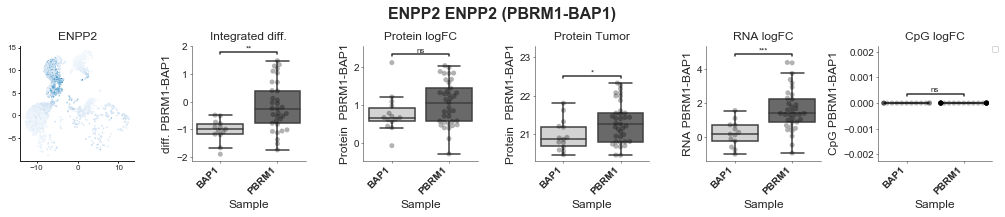

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.792e-03 U_stat=8.600e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.734e-01 U_stat=1.940e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.652e-01 U_stat=2.380e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.710e-04 U_stat=6.500e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02
https://www.proteinatlas.org/ENSG00000119630-PGF/pathology/renal+cancer/KIRC


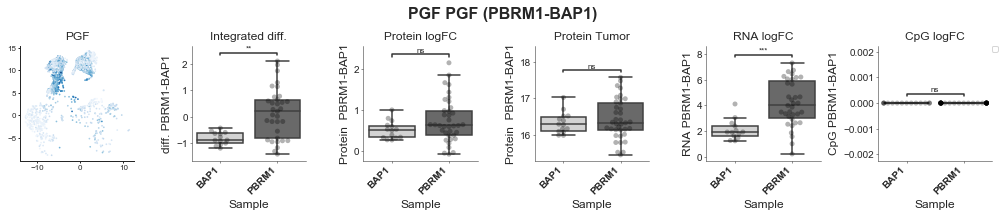

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.024e-03 U_stat=9.900e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.773e-04 U_stat=9.300e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.586e-04 U_stat=9.500e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.593e-02 U_stat=1.310e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02
https://www.proteinatlas.org/ENSG00000174705-SH3PXD2B/pathology/renal+cancer/KIRC


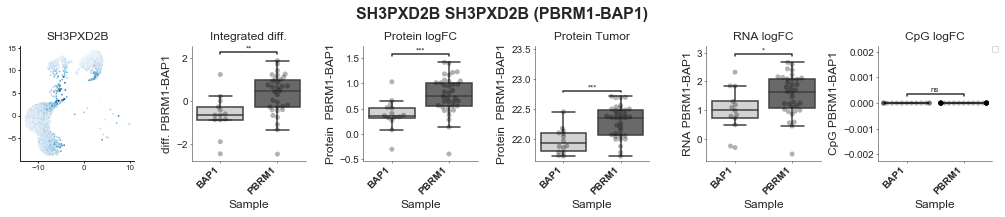

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.918e-03 U_stat=9.200e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.770e-01 U_stat=2.070e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.477e-02 U_stat=1.710e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.863e-04 U_stat=8.500e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02
https://www.proteinatlas.org/ENSG00000176973-FAM89B/pathology/renal+cancer/KIRC


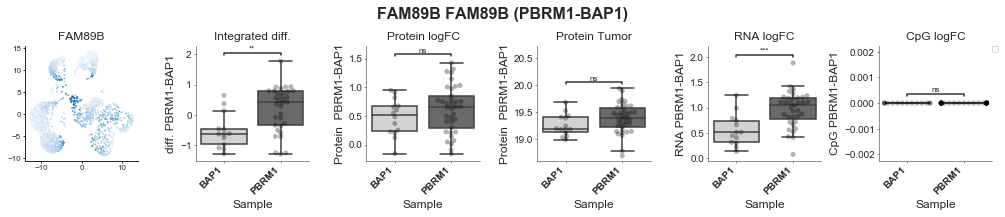

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.656e-03 U_stat=9.800e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.943e-01 U_stat=1.970e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.539e-02 U_stat=1.770e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.372e-03 U_stat=9.600e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.877e-01 U_stat=2.700e+02
https://www.proteinatlas.org/ENSG00000164283-ESM1/pathology/renal+cancer/KIRC


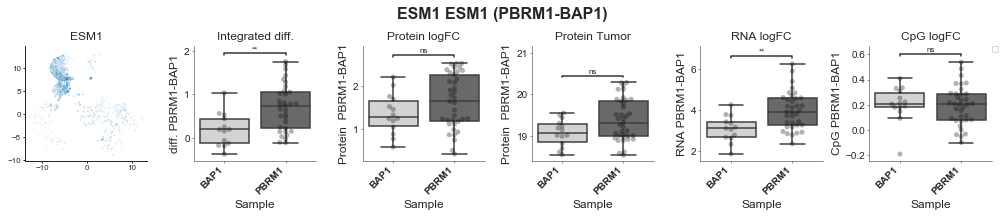

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.158e-03 U_stat=9.300e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.609e-02 U_stat=1.640e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.217e-02 U_stat=1.570e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.080e-04 U_stat=8.400e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.207e-01 U_stat=2.400e+02
https://www.proteinatlas.org/ENSG00000152583-SPARCL1/pathology/renal+cancer/KIRC


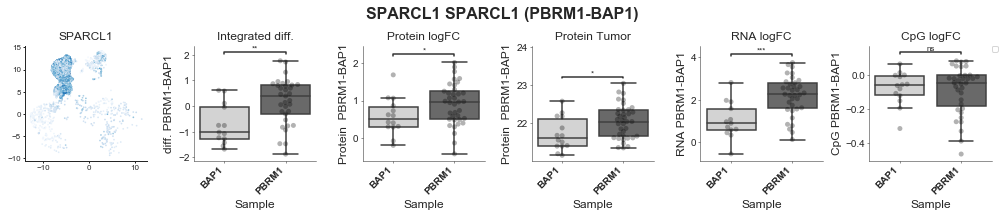

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.311e-04 U_stat=7.700e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.158e-01 U_stat=1.840e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.082e-02 U_stat=1.490e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.956e-04 U_stat=7.900e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.850e-02 U_stat=3.250e+02
https://www.proteinatlas.org/ENSG00000102755-FLT1/pathology/renal+cancer/KIRC


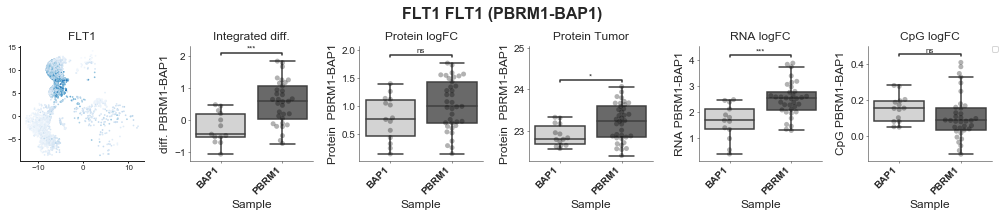

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.918e-03 U_stat=9.200e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.892e-02 U_stat=1.550e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.757e-02 U_stat=1.460e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.766e-03 U_stat=1.080e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02


No handles with labels found to put in legend.


https://www.proteinatlas.org/ENSG00000081189-MEF2C/pathology/renal+cancer/KIRC


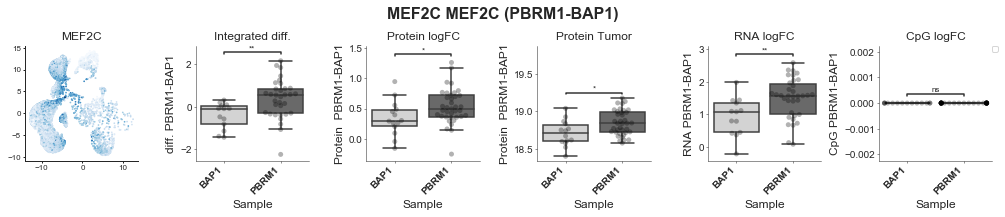

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.694e-03 U_stat=3.380e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.196e-03 U_stat=4.130e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.049e-04 U_stat=4.200e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.022e-02 U_stat=3.090e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02


No handles with labels found to put in legend.


https://www.proteinatlas.org/ENSG00000254087-LYN/pathology/renal+cancer/KIRC


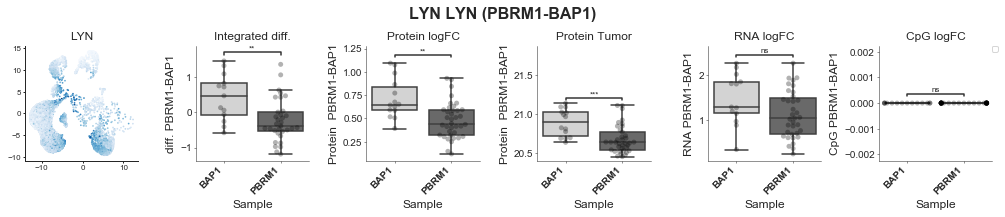

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.964e-04 U_stat=3.540e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.455e-03 U_stat=4.030e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.463e-03 U_stat=3.980e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.017e-03 U_stat=3.520e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.508e-01 U_stat=2.540e+02


No handles with labels found to put in legend.


https://www.proteinatlas.org/ENSG00000140678-ITGAX/pathology/renal+cancer/KIRC


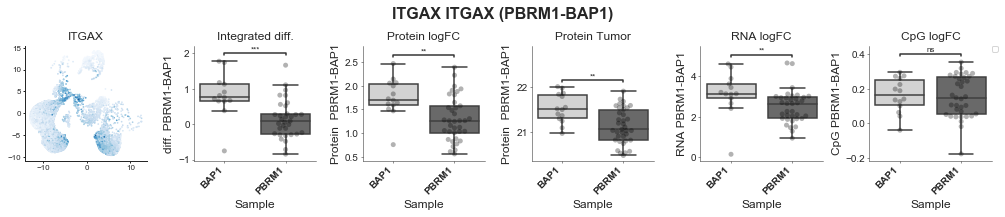

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.918e-03 U_stat=3.370e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.314e-02 U_stat=3.770e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.526e-04 U_stat=4.210e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.920e-02 U_stat=3.220e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.991e-01 U_stat=2.330e+02
https://www.proteinatlas.org/ENSG00000088827-SIGLEC1/pathology/renal+cancer/KIRC


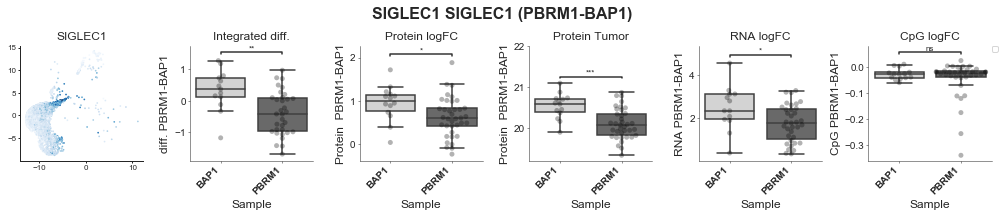

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.822e-04 U_stat=3.560e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.511e-03 U_stat=3.910e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.612e-04 U_stat=4.190e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.558e-04 U_stat=3.910e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02


No handles with labels found to put in legend.


https://www.proteinatlas.org/ENSG00000012779-ALOX5/pathology/renal+cancer/KIRC


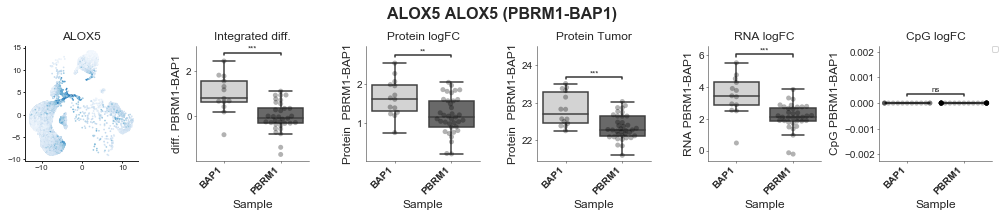

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.113e-03 U_stat=3.410e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.860e-02 U_stat=3.710e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.424e-01 U_stat=3.290e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.796e-02 U_stat=3.300e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.157e-03 U_stat=1.150e+02
https://www.proteinatlas.org/ENSG00000146070-PLA2G7/pathology/renal+cancer/KIRC


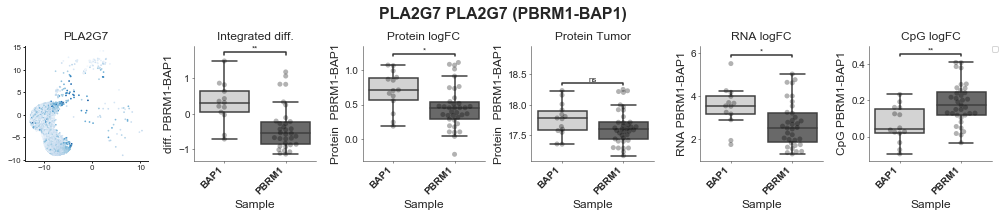

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.313e-03 U_stat=3.320e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.761e-02 U_stat=3.580e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.314e-02 U_stat=3.770e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.687e-02 U_stat=3.310e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02


No handles with labels found to put in legend.


https://www.proteinatlas.org/ENSG00000136235-GPNMB/pathology/renal+cancer/KIRC


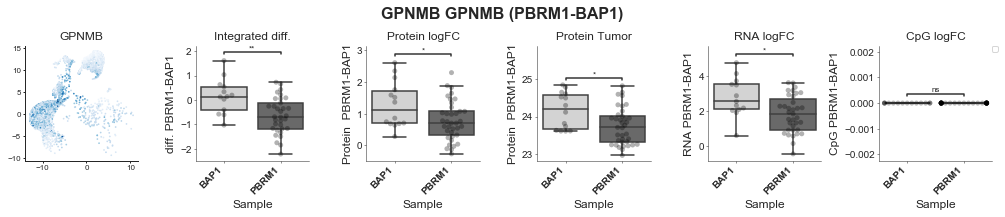

In [240]:
# only plot genes once
from collections import defaultdict
from sciutil import SciUtil

u = SciUtil()

cond1 = run_label.split('-')[0]
cond0 = run_label.split('-')[1]

to_plots = ['TPDE (+)', 'TPDE (-)']
gene_map = gene_name_map
# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html
for cat in to_plots:
    genes = plotting_gene_map[cat]
    gene_names = []
    gene_names = [gene_name_map.get(g) for g in genes]
    p_vals = [gene_padj_map.get(g) for g in genes]
    
    #u.dp([cell_types[i], labels[i], len(genes)])
    for i, ensembl_id in enumerate(genes):
        #if not seen_genes.get(ensembl_id):
        plot_gene(ensembl_id, cond0, cond1, x="Mutation", cmap='Blues', label=f'{gene_names[i]}')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.289e-03 U_stat=3.270e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.113e-02 U_stat=1.730e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.113e-02 U_stat=1.730e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.162e-03 U_stat=8.700e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.997e-01 U_stat=2.140e+02
https://www.proteinatlas.org/ENSG00000138722-MMRN1/pathology/renal+cancer/KIRC


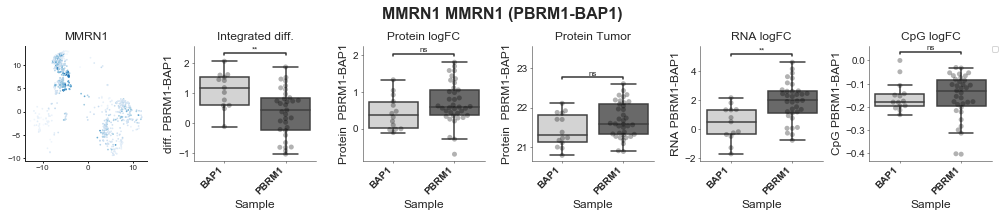

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.964e-04 U_stat=3.540e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.314e-02 U_stat=1.410e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.632e-03 U_stat=1.160e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.597e-04 U_stat=7.600e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.357e-01 U_stat=2.890e+02
https://www.proteinatlas.org/ENSG00000170962-PDGFD/pathology/renal+cancer/KIRC


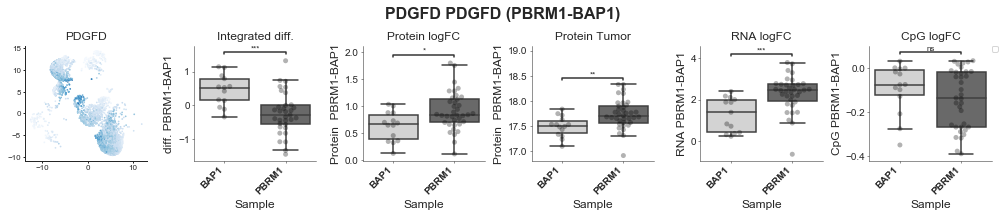

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.822e-04 U_stat=3.560e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.721e-03 U_stat=1.360e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.039e-04 U_stat=9.600e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.604e-03 U_stat=9.100e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.330e-02 U_stat=3.480e+02


No handles with labels found to put in legend.


https://www.proteinatlas.org/ENSG00000024422-EHD2/pathology/renal+cancer/KIRC


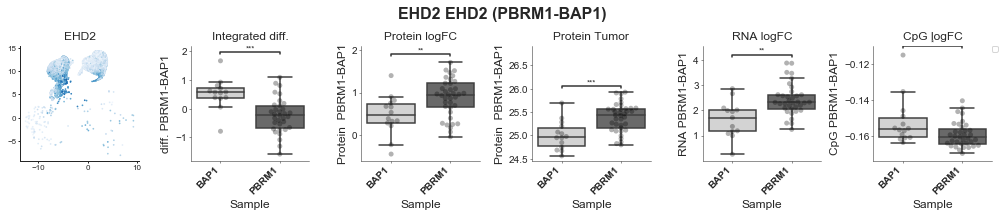

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.742e-05 U_stat=3.840e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.500e-01 U_stat=2.040e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.909e-01 U_stat=2.660e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.372e-06 U_stat=3.600e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.157e-03 U_stat=3.750e+02
https://www.proteinatlas.org/ENSG00000132639-SNAP25/pathology/renal+cancer/KIRC


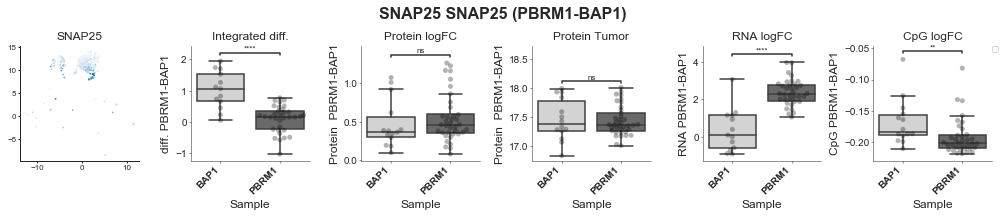

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.313e-03 U_stat=3.320e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.166e-02 U_stat=1.390e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.773e-04 U_stat=9.300e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.369e-03 U_stat=1.070e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.852e-02 U_stat=3.390e+02


No handles with labels found to put in legend.


https://www.proteinatlas.org/ENSG00000105974-CAV1/pathology/renal+cancer/KIRC


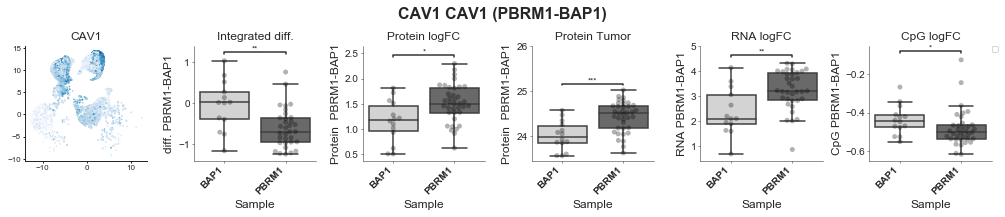

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.049e-04 U_stat=3.740e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.987e-03 U_stat=1.120e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.189e-05 U_stat=5.100e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.180e-05 U_stat=4.400e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.898e-05 U_stat=4.270e+02
https://www.proteinatlas.org/ENSG00000185100-ADSS1/pathology/renal+cancer/KIRC


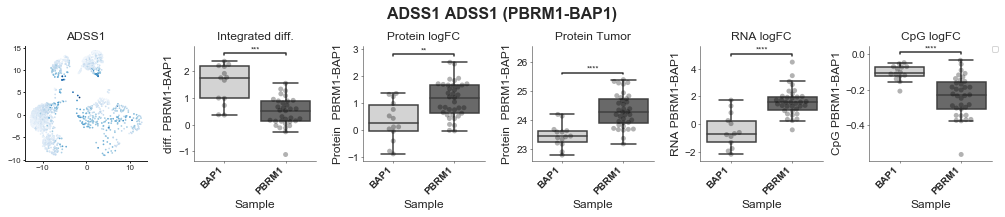

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.417e-03 U_stat=3.290e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.888e-02 U_stat=1.690e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.930e-02 U_stat=1.780e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.366e-03 U_stat=1.150e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.898e-05 U_stat=4.270e+02
https://www.proteinatlas.org/ENSG00000173548-SNX33/pathology/renal+cancer/KIRC


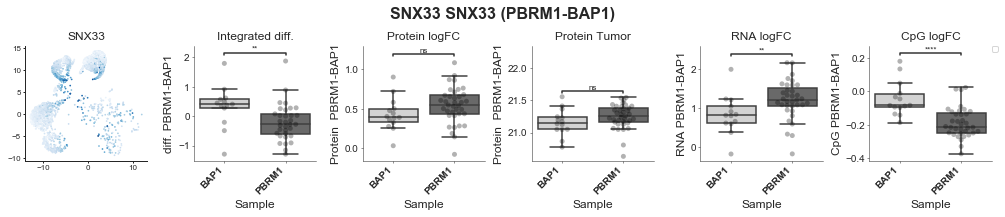

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.176e-03 U_stat=3.480e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.502e-04 U_stat=8.500e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.948e-04 U_stat=8.700e+01


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.323e-03 U_stat=1.040e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.381e-01 U_stat=2.490e+02
https://www.proteinatlas.org/ENSG00000091127-PUS7/pathology/renal+cancer/KIRC


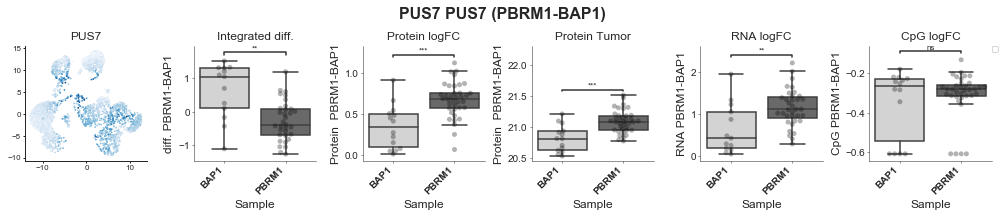

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.283e-02 U_stat=3.170e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.761e-02 U_stat=1.600e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.892e-02 U_stat=1.550e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.593e-02 U_stat=1.310e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.822e-01 U_stat=2.260e+02
https://www.proteinatlas.org/ENSG00000116991-SIPA1L2/pathology/renal+cancer/KIRC


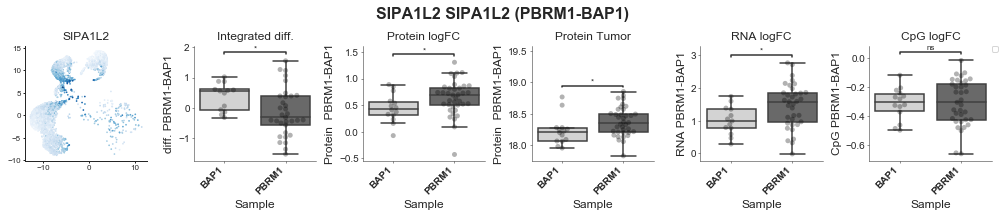

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.158e-03 U_stat=9.300e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.761e-02 U_stat=3.580e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.455e-03 U_stat=4.030e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.468e-04 U_stat=3.860e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.929e-03 U_stat=1.280e+02


No handles with labels found to put in legend.


https://www.proteinatlas.org/ENSG00000103490-PYCARD/pathology/renal+cancer/KIRC


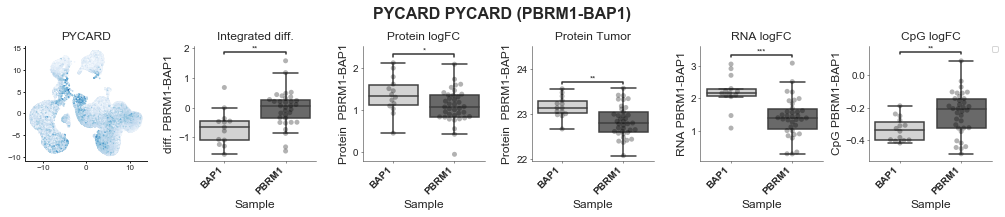

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.417e-03 U_stat=1.000e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.044e-01 U_stat=2.990e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.243e-01 U_stat=2.540e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.879e-03 U_stat=3.620e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.508e-01 U_stat=2.540e+02


No handles with labels found to put in legend.


https://www.proteinatlas.org/ENSG00000161921-CXCL16/pathology/renal+cancer/KIRC


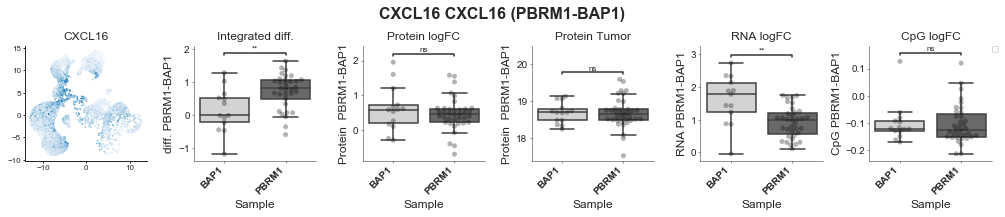

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.113e-03 U_stat=8.800e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.594e-03 U_stat=3.840e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.527e-03 U_stat=3.940e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.752e-02 U_stat=3.230e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.585e-01 U_stat=2.790e+02


No handles with labels found to put in legend.


https://www.proteinatlas.org/ENSG00000059377-TBXAS1/pathology/renal+cancer/KIRC


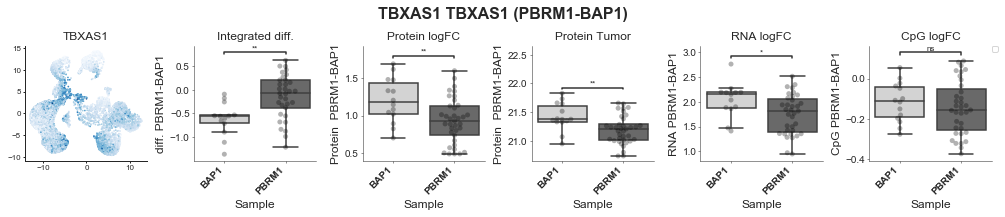

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.822e-04 U_stat=7.300e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.879e-03 U_stat=3.900e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.072e-04 U_stat=4.270e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.014e-04 U_stat=3.780e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.131e-03 U_stat=1.110e+02


No handles with labels found to put in legend.


https://www.proteinatlas.org/ENSG00000100364-KIAA0930/pathology/renal+cancer/KIRC


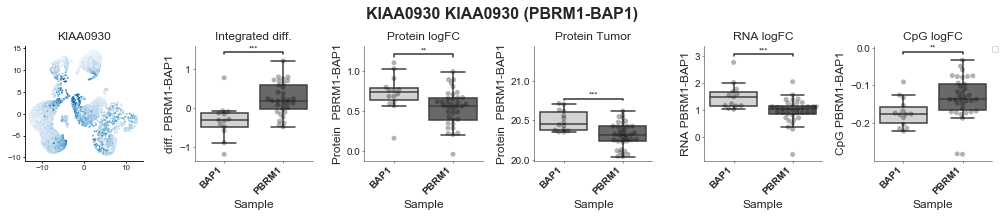

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.024e-03 U_stat=9.900e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.033e-02 U_stat=3.810e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.022e-03 U_stat=4.000e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.732e-03 U_stat=3.530e+02


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.520e-03 U_stat=1.080e+02


No handles with labels found to put in legend.


https://www.proteinatlas.org/ENSG00000131446-MGAT1/pathology/renal+cancer/KIRC


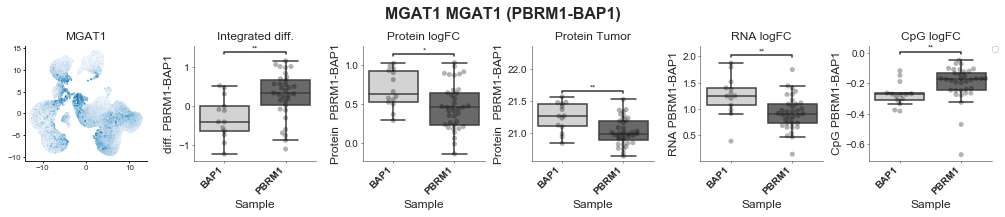

In [241]:
# only plot genes once
from collections import defaultdict
from sciutil import SciUtil

u = SciUtil()

cond1 = run_label.split('-')[0]
cond0 = run_label.split('-')[1]

to_plots = ['MDE (+)', 'MDE (-)']
gene_map = gene_name_map
# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html
for cat in to_plots:
    genes = plotting_gene_map[cat]
    gene_names = []
    gene_names = [gene_name_map.get(g) for g in genes]
    p_vals = [gene_padj_map.get(g) for g in genes]
    
    #u.dp([cell_types[i], labels[i], len(genes)])
    for i, ensembl_id in enumerate(genes):
        #if not seen_genes.get(ensembl_id):
        plot_gene(ensembl_id, cond0, cond1, x="Mutation", cmap='Blues', label=f'{gene_names[i]}')

In [225]:
umap = pd.DataFrame()
umap['UMAP_1'] = data_sub_regulatory.obs['UMAP1']
umap['UMAP_2'] = data_sub_regulatory.obs['UMAP2']


In [151]:
new_df

CD8A+ NK-like  CD8A+ Proliferating  CD8A+ Exhausted IEG  \
GeneId                                                                     
ENSG00000074527      -0.276008            -0.304237             0.000000   
ENSG00000139344       0.295444             0.199317             0.026160   
ENSG00000173598      -0.468079            -0.236428             0.342080   
ENSG00000005108      -0.378480            -0.380832             0.000000   
ENSG00000127955      -0.558010            -0.593288            -0.593262   
...                        ...                  ...                  ...   
ENSG00000139410      -0.699150            -0.699891            -0.705956   
ENSG00000105519      -0.117743            -0.470233            -0.253329   
ENSG00000211445      -0.384077            -0.394517            -0.395664   
ENSG00000136463       0.119975             0.825809            -0.450069   
ENSG00000127884      -0.311835             0.902444            -0.098778   

                 Conventional NK  CD8A+ Tissue-resident  \
GeneId                                                    
ENSG00000074527        -0.306635              -0.300175   
ENSG00000139344         0.681421              -0.468235   
ENSG00000173598        -0.752211              -0.068235   
ENSG00000005108         0.000000              -0.378062   
ENSG00000127955         0.000000              -0.585312   
...                          ...                    ...   
ENSG00000139410        -0.692704              -0.702567   
ENSG00000105519        -0.272540              -0.104661   
ENSG00000211445        -0.396397              -0.349564   
ENSG00000136463         0.101759              -0.733883   
ENSG00000127884        -0.755525              -0.585870   

                 CD45- Vascular Endothelium   NK HSP+  CD4+ Activated IEG  \
GeneId                                                                      
ENSG00000074527                    5.146793 -0.247993           -0.266744   
ENSG00000139344                    0.480460  0.074840           -0.422046   
ENSG00000173598                   -0.075089  0.400036            0.321905   
ENSG00000005108                    4.493090 -0.373782           -0.373046   
ENSG00000127955                    1.983611 -0.548228           -0.575205   
...                                     ...       ...                 ...   
ENSG00000139410                   -0.626136 -0.701253           -0.706513   
ENSG00000105519                   -0.031030 -0.083588           -0.130675   
ENSG00000211445                    0.743414 -0.357276           -0.370125   
ENSG00000136463                   -0.394571 -0.714884           -0.483887   
ENSG00000127884                   -0.225491 -0.802576           -0.706188   

                 TAM/TCR (Ambiguos)  CD45- PAX8+ renal epithelium  ...  \
GeneId                                                             ...   
ENSG00000074527           -0.302122                      0.167731  ...   
ENSG00000139344            0.130349                      4.860369  ...   
ENSG00000173598           -0.376924                      0.969168  ...   
ENSG00000005108           -0.375990                      0.938595  ...   
ENSG00000127955           -0.163492                      0.482585  ...   
...                             ...                           ...  ...   
ENSG00000139410            1.584300                      1.611532  ...   
ENSG00000105519           -0.289470                      3.162009  ...   
ENSG00000211445           -0.137042                      5.161624  ...   
ENSG00000136463            0.352576                      3.106456  ...   
ENSG00000127884            0.626683                      3.479710  ...   

                 CD4+ Treg  TAM ISGhi      cDC1  Megakaryocyte       pDC  \
GeneId                                                                     
ENSG00000074527   0.000000   1.449918 -0.280201       0.000000  0.000000   
ENSG00000139344  -0.451031  -0.341390  0.000000       0.000000 -0.2

In [160]:
# Make a square dataframe based on the odds ratio
cluster_labels = new_df['RegulatoryCluster'].unique()

# Let's get an ordered dict of the values so that we can use them later
plotting_gene_map_cell = defaultdict(list) # Get the sig ones since we don't want to plot all!
for cluster in cluster_labels:
    r_df = new_df[new_df['RegulatoryCluster'] == cluster]
    if len(r_df) > 0:
        gene_to_value = {}
        for i, gene in enumerate(r_df.index.values):
            for column in r_df:
                gene_to_value[gene] = r_df[column].values[i]
        # Sort gene_to_value
        gene_to_value_sorted = dict(sorted(gene_to_value.items(), key=lambda item: item[1]))
        # Get the genes for each of the cell types
        plotting_gene_map_cell[cluster] += list(gene_to_value_sorted.keys())[:5]
    else:
        values.append(0)
# Make sure there weren't any duplicates
for c in plotting_gene_map_cell:
    plotting_gene_map_cell[c] = list(set(plotting_gene_map_cell[c]))

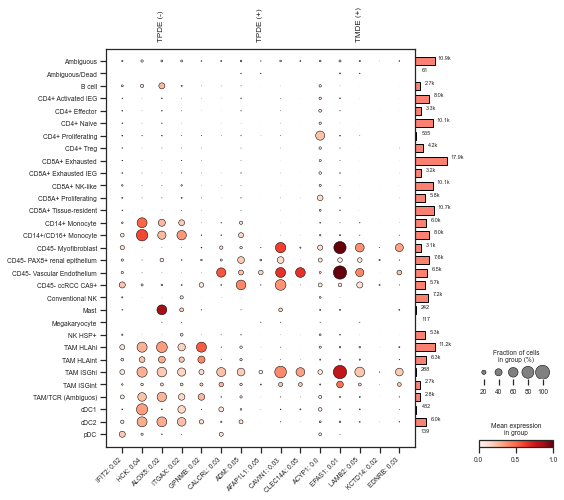

In [161]:
categories_order={'All': list(plotting_gene_map.keys())}
categories_order={'TPDE': ['TPDE (-)', 'TPDE (+)', 'TMDE (+)']}
#categories_order={'TPDE': ['TPDE (+)', 'TPDE (-)'], 'MDE': ['MDE (+)', 'MDE (-)']}

# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html
for cat in categories_order:
    fig, ax = plt.subplots(figsize=(8,8))
    plt_plotting_gene_map = {k:plotting_gene_map_cell[k] for k in categories_order[cat]}

    dpl = sc.pl.dotplot(
        data_sub_regulatory,
        var_names=plt_plotting_gene_map,
        #values_to_plot="logfoldchanges",
        cmap='Reds',
        vmin=0,
        vmax=1,
#         min_logfoldchange=3,
#         colorbar_title='log fold change',
#         show = False, 
        ax=ax,
        swap_axes=False,
        #dendogram=False,
        groupby='cluster_name',
        return_fig=True
    )
    dpl.add_totals().style(dot_edge_color='black', cmap='Reds', dot_edge_lw=0.5)

    ax_all = dpl.get_axes()
    ax = ax_all['mainplot_ax']
    # Rename to gene names
    labels = [f'{gene_name_map.get(item.get_text())}: {round(gene_padj_map[item.get_text()], 2)}' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')

    # Rename the ensembl gene IDs to the gene name 
    if save_figs:
        plt.savefig(f'{output_dir}{run_label}_{cat}_rank_genes.svg')
    plt.show()


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.742e-05 U_stat=4.500e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.164e-04 U_stat=9.400e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.931e-05 U_stat=7.000e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.392e-02 U_stat=1.210e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.599e-01 U_stat=1.810e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


https://www.proteinatlas.org/ENSG00000119640-ACYP1/pathology/renal+cancer/KIRC


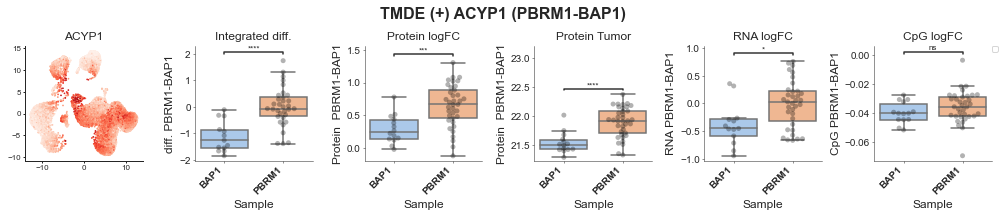

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.176e-03 U_stat=8.100e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.987e-03 U_stat=1.120e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.049e-04 U_stat=9.800e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.222e-02 U_stat=1.190e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.064e-02 U_stat=3.380e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


https://www.proteinatlas.org/ENSG00000116016-EPAS1/pathology/renal+cancer/KIRC


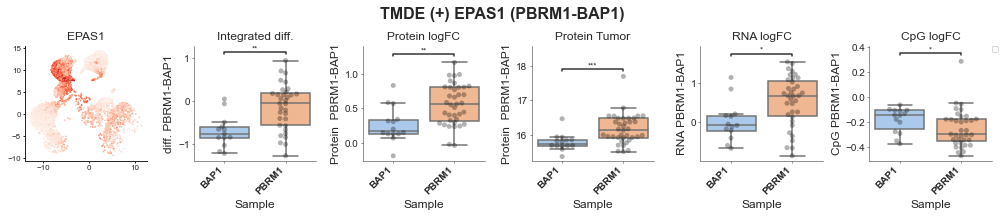

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.042e-02 U_stat=1.090e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.383e-02 U_stat=1.630e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.793e-04 U_stat=8.100e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.145e-02 U_stat=1.180e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.822e-04 U_stat=4.060e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


https://www.proteinatlas.org/ENSG00000172037-LAMB2/pathology/renal+cancer/KIRC


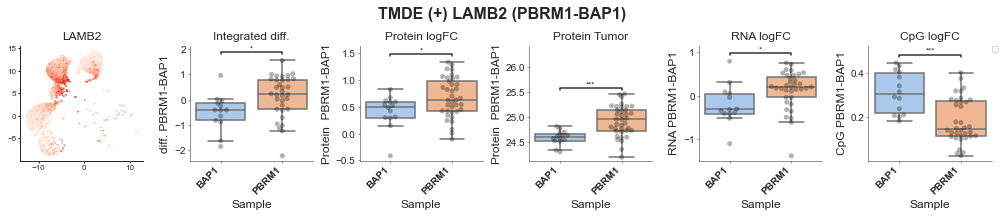

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.486e-03 U_stat=9.000e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.383e-02 U_stat=1.630e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.110e-03 U_stat=1.040e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.232e-04 U_stat=7.200e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.478e-03 U_stat=3.710e+02
https://www.proteinatlas.org/ENSG00000151364-KCTD14/pathology/renal+cancer/KIRC


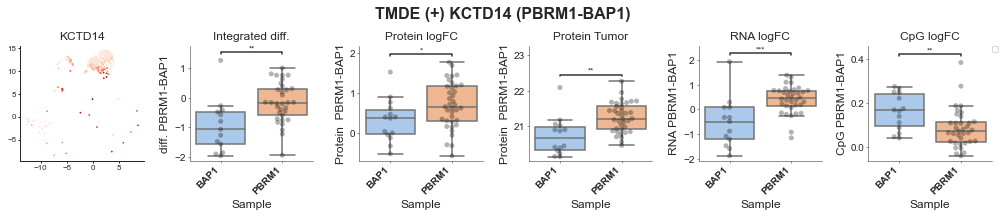

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.313e-03 U_stat=9.700e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.761e-02 U_stat=1.600e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.741e-02 U_stat=1.540e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.561e-03 U_stat=9.700e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.631e-02 U_stat=1.670e+02
https://www.proteinatlas.org/ENSG00000136160-EDNRB/pathology/renal+cancer/KIRC


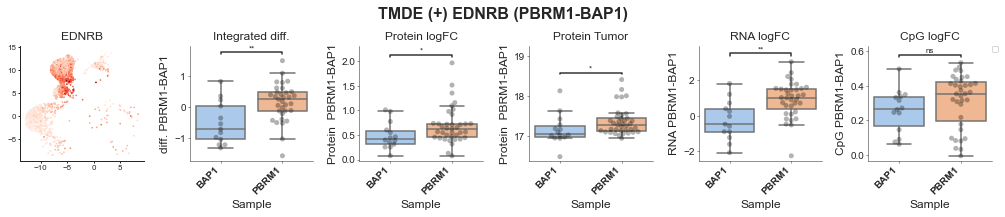

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.420e-03 U_stat=1.060e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.335e-02 U_stat=1.790e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.741e-02 U_stat=1.540e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.354e-04 U_stat=8.300e+01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.311e-03 U_stat=3.630e+02
https://www.proteinatlas.org/ENSG00000064989-CALCRL/pathology/renal+cancer/KIRC


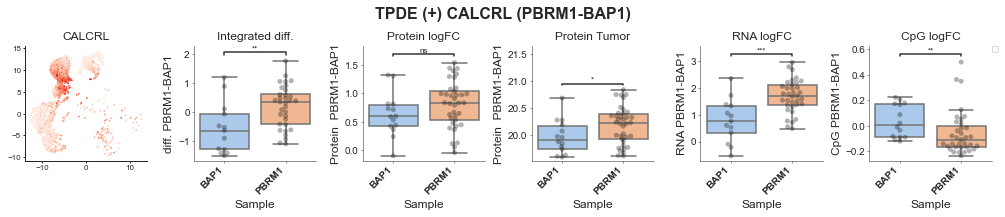

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.918e-02 U_stat=1.180e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.276e-01 U_stat=2.420e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.367e-01 U_stat=1.880e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.299e-02 U_stat=1.290e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.985e-01 U_stat=2.270e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


https://www.proteinatlas.org/ENSG00000148926-ADM/pathology/renal+cancer/KIRC


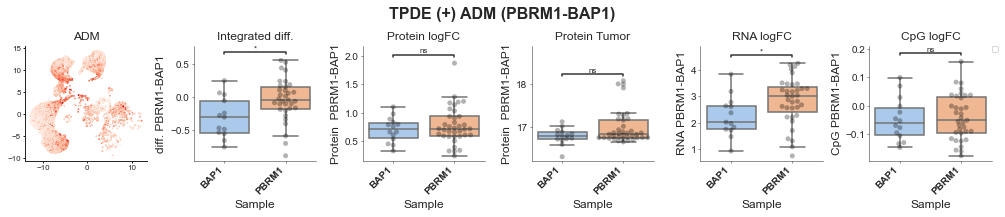

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.047e-02 U_stat=1.190e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.860e-02 U_stat=1.470e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.237e-03 U_stat=1.230e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.602e-02 U_stat=1.410e+02


/Users/ariane/opt/miniconda3/envs/BINF/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/BINF/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02
https://www.proteinatlas.org/ENSG00000157510-AFAP1L1/pathology/renal+cancer/KIRC


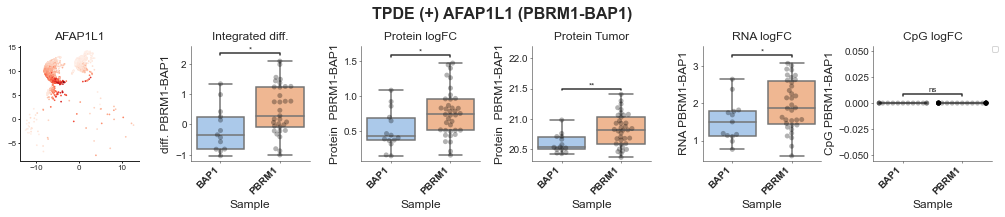

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.198e-02 U_stat=1.110e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.390e-02 U_stat=1.580e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.632e-03 U_stat=1.160e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.687e-02 U_stat=1.240e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.247e-01 U_stat=2.900e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


https://www.proteinatlas.org/ENSG00000177469-CAVIN1/pathology/renal+cancer/KIRC


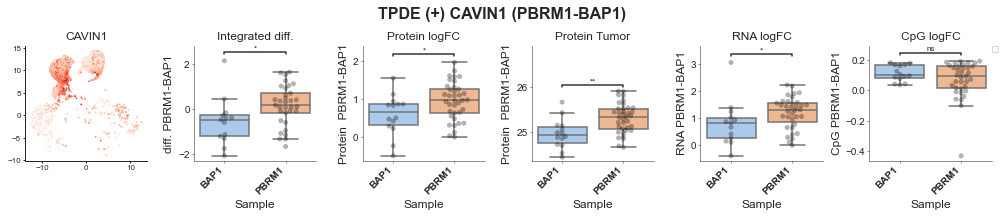

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.328e-02 U_stat=1.210e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.865e-01 U_stat=2.080e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.163e-02 U_stat=1.760e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.465e-03 U_stat=1.010e+02


/Users/ariane/opt/miniconda3/envs/BINF/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/BINF/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02
https://www.proteinatlas.org/ENSG00000176435-CLEC14A/pathology/renal+cancer/KIRC


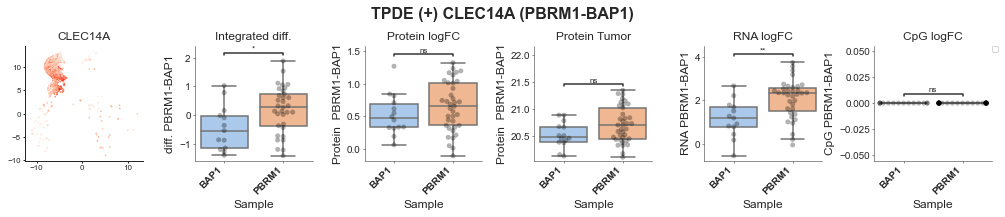

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.839e-03 U_stat=3.280e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.511e-03 U_stat=3.910e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.511e-03 U_stat=3.910e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.189e-03 U_stat=3.460e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/ariane/opt/miniconda3/envs/BINF/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/BINF/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


https://www.proteinatlas.org/ENSG00000119922-IFIT2/pathology/renal+cancer/KIRC


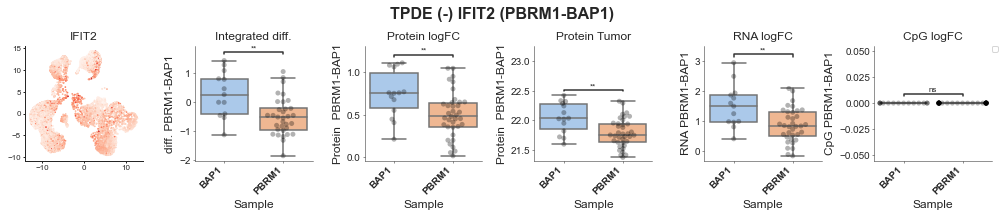

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.470e-02 U_stat=3.150e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.761e-02 U_stat=3.580e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.683e-03 U_stat=3.880e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.132e-02 U_stat=3.120e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.822e-01 U_stat=2.260e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


https://www.proteinatlas.org/ENSG00000101336-HCK/pathology/renal+cancer/KIRC


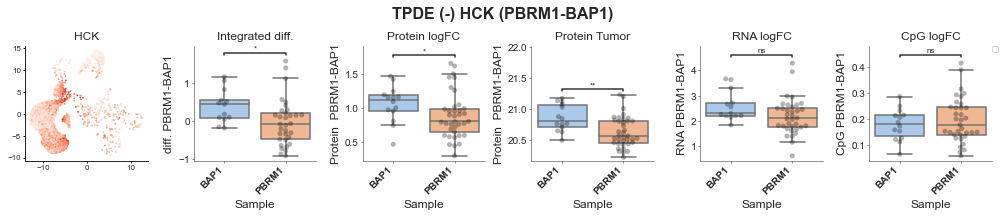

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.822e-04 U_stat=3.560e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.511e-03 U_stat=3.910e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.612e-04 U_stat=4.190e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.558e-04 U_stat=3.910e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/ariane/opt/miniconda3/envs/BINF/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/BINF/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


https://www.proteinatlas.org/ENSG00000012779-ALOX5/pathology/renal+cancer/KIRC


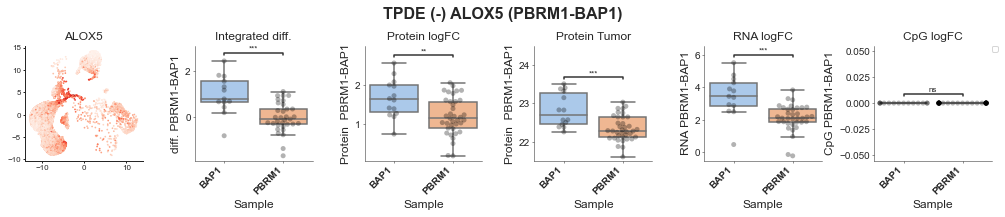

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.964e-04 U_stat=3.540e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.455e-03 U_stat=4.030e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.463e-03 U_stat=3.980e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.017e-03 U_stat=3.520e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.508e-01 U_stat=2.540e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


https://www.proteinatlas.org/ENSG00000140678-ITGAX/pathology/renal+cancer/KIRC


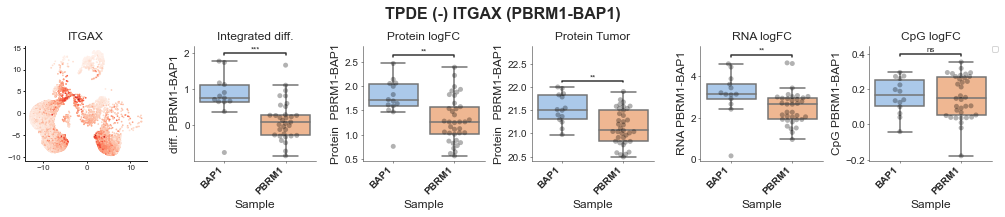

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.313e-03 U_stat=3.320e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.761e-02 U_stat=3.580e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.314e-02 U_stat=3.770e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.687e-02 U_stat=3.310e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/ariane/opt/miniconda3/envs/BINF/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ariane/opt/miniconda3/envs/BINF/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BAP1 v.s. PBRM1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+02


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


https://www.proteinatlas.org/ENSG00000136235-GPNMB/pathology/renal+cancer/KIRC


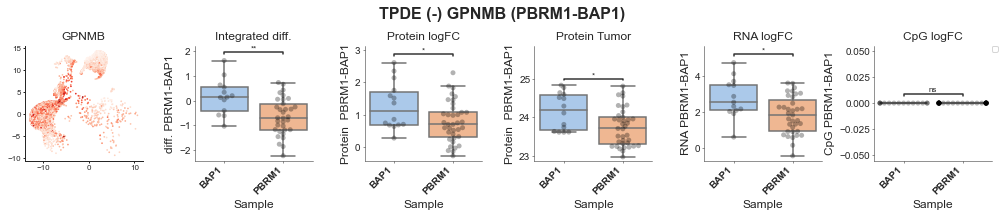

In [167]:
#u.dp([cell_types[i], labels[i], len(genes)])
for grp, ensembl_ids in plotting_gene_map_cell.items():
    if grp in ['TMDE (+)', 'TPDE (+)', 'TPDE (-)']:
        for ensembl_id in ensembl_ids:
        #if not seen_genes.get(ensembl_id):
            plot_gene(ensembl_id, cond0, cond1, x="Mutation", cmap='Reds', label=f'{grp}')


In [138]:
cell_types = sig_odds_ratio_df['Cell type'].unique()
cluster_labels = sig_odds_ratio_df['Regulatory Cluster label'].unique()

# Let's get an ordered dict of the values so that we can use them later
plotting_gene_map = defaultdict(list) # Get the sig ones since we don't want to plot all!
for cell_type in cell_types:
    values = [cell_type]
    for cluster in cluster_labels:
        cell = sig_odds_ratio_df[sig_odds_ratio_df['Cell type'] == cell_type]
        if len(cell) > 0:
            cell_cluster = cell[cell['Regulatory Cluster label'] == cluster]
            if len(cell_cluster) > 0:
                values.append(cell_cluster['odds-ratio'].values[0])
                # get the genes in this group
                genes = cell_cluster['gene_ids'].values[0].split(' ')
                
                # Add the genes from this group
                gene_to_value = {g:gene_padj_map[g] for g in genes}
                # Sort gene_to_value
                gene_to_value_sorted = dict(sorted(gene_to_value.items(), key=lambda item: item[1]))
                # Get the genes for each of the cell types
                plotting_gene_map[cluster] += list(gene_to_value_sorted.keys())[:10]
                
# Make sure there weren't any duplicates
for c in plotting_gene_map:
    plotting_gene_map[c] = list(set(plotting_gene_map[c]))

In [169]:
new_df

CD8A+ NK-like  CD8A+ Proliferating  CD8A+ Exhausted IEG  \
GeneId                                                                     
ENSG00000074527      -0.276008            -0.304237             0.000000   
ENSG00000139344       0.295444             0.199317             0.026160   
ENSG00000173598      -0.468079            -0.236428             0.342080   
ENSG00000005108      -0.378480            -0.380832             0.000000   
ENSG00000127955      -0.558010            -0.593288            -0.593262   
...                        ...                  ...                  ...   
ENSG00000139410      -0.699150            -0.699891            -0.705956   
ENSG00000105519      -0.117743            -0.470233            -0.253329   
ENSG00000211445      -0.384077            -0.394517            -0.395664   
ENSG00000136463       0.119975             0.825809            -0.450069   
ENSG00000127884      -0.311835             0.902444            -0.098778   

                 Conventional NK  CD8A+ Tissue-resident  \
GeneId                                                    
ENSG00000074527        -0.306635              -0.300175   
ENSG00000139344         0.681421              -0.468235   
ENSG00000173598        -0.752211              -0.068235   
ENSG00000005108         0.000000              -0.378062   
ENSG00000127955         0.000000              -0.585312   
...                          ...                    ...   
ENSG00000139410        -0.692704              -0.702567   
ENSG00000105519        -0.272540              -0.104661   
ENSG00000211445        -0.396397              -0.349564   
ENSG00000136463         0.101759              -0.733883   
ENSG00000127884        -0.755525              -0.585870   

                 CD45- Vascular Endothelium   NK HSP+  CD4+ Activated IEG  \
GeneId                                                                      
ENSG00000074527                    5.146793 -0.247993           -0.266744   
ENSG00000139344                    0.480460  0.074840           -0.422046   
ENSG00000173598                   -0.075089  0.400036            0.321905   
ENSG00000005108                    4.493090 -0.373782           -0.373046   
ENSG00000127955                    1.983611 -0.548228           -0.575205   
...                                     ...       ...                 ...   
ENSG00000139410                   -0.626136 -0.701253           -0.706513   
ENSG00000105519                   -0.031030 -0.083588           -0.130675   
ENSG00000211445                    0.743414 -0.357276           -0.370125   
ENSG00000136463                   -0.394571 -0.714884           -0.483887   
ENSG00000127884                   -0.225491 -0.802576           -0.706188   

                 TAM/TCR (Ambiguos)  CD45- PAX8+ renal epithelium  ...  \
GeneId                                                             ...   
ENSG00000074527           -0.302122                      0.167731  ...   
ENSG00000139344            0.130349                      4.860369  ...   
ENSG00000173598           -0.376924                      0.969168  ...   
ENSG00000005108           -0.375990                      0.938595  ...   
ENSG00000127955           -0.163492                      0.482585  ...   
...                             ...                           ...  ...   
ENSG00000139410            1.584300                      1.611532  ...   
ENSG00000105519           -0.289470                      3.162009  ...   
ENSG00000211445           -0.137042                      5.161624  ...   
ENSG00000136463            0.352576                      3.106456  ...   
ENSG00000127884            0.626683                      3.479710  ...   

                 CD4+ Treg  TAM ISGhi      cDC1  Megakaryocyte       pDC  \
GeneId                                                                     
ENSG00000074527   0.000000   1.449918 -0.280201       0.000000  0.000000   
ENSG00000139344  -0.451031  -0.341390  0.000000       0.000000 -0.2

In [177]:
new_df[new_df['GeneName'] == 'SERPINE1']['SigCellCluster'].values

array([], dtype=object)

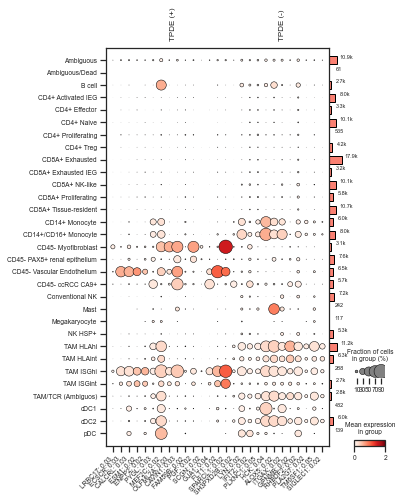

In [139]:
categories_order={'All': list(plotting_gene_map.keys())}
categories_order={'TPDE': ['TPDE (+)', 'TPDE (-)']}
#categories_order={'TPDE': ['TPDE (+)', 'TPDE (-)'], 'MDE': ['MDE (+)', 'MDE (-)']}

# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html
for cat in categories_order:
    fig, ax = plt.subplots(figsize=(5,8))
    plt_plotting_gene_map = {k:plotting_gene_map[k] for k in categories_order[cat]}

    dpl = sc.pl.dotplot(
        data_sub_regulatory,
        var_names=plt_plotting_gene_map,
        #values_to_plot="logfoldchanges",
        cmap='Reds',
        vmin=0,
        vmax=2,
#         min_logfoldchange=3,
#         colorbar_title='log fold change',
#         show = False, 
        ax=ax,
        swap_axes=False,
        #dendogram=False,
        groupby='cluster_name',
        return_fig=True
    )
    dpl.add_totals().style(dot_edge_color='black', cmap='Reds', dot_edge_lw=0.5)

    ax_all = dpl.get_axes()
    ax = ax_all['mainplot_ax']
    # Rename to gene names
    labels = [f'{gene_name_map.get(item.get_text())}: {round(gene_padj_map[item.get_text()], 2)}' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')

    # Rename the ensembl gene IDs to the gene name 
    if save_figs:
        plt.savefig(f'{output_dir}{run_label}_{cat}_rank_genes.svg')
    plt.show()
